In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import pickle
import random
import seaborn as sns
import torch

In [2]:
# avoid type-3 fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


ALPHA = 0.3
# COLORS = sns.color_palette('muted')
COLORS = cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def decorate_axis(ax, wrect=10, hrect=10, labelsize='large', scale_ticks=True):
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    # Deal with ticks and the blank space at the origin
    if scale_ticks:
        ax.tick_params(length=0.1, width=0.1, labelsize=labelsize)
    else:
        ax.tick_params(labelsize=labelsize)
    # Pablos' comment
    ax.spines['left'].set_position(('outward', hrect))
    ax.spines['bottom'].set_position(('outward', wrect))


def annotate_and_decorate_axis(
    ax,
    xlabel,
    ylabel,
    ylabel_color=None,
    wrect=10,
    hrect=10,
    grid_alpha=1,
    labelsize='large',
    ticklabelsize='large',
    scale_ticks=True,
):
    ax.set_xlabel(xlabel, fontsize=labelsize)
    if ylabel_color is not None:
        ax.set_ylabel(ylabel, fontsize=labelsize, color=ylabel_color)
    else:
        ax.set_ylabel(ylabel, fontsize=labelsize)
    ax.grid(True, alpha=grid_alpha)
    decorate_axis(ax, wrect, hrect, ticklabelsize, scale_ticks)
    
def export_legend(lines, save_path):
    # Lines to show on legend and their labels
    labels = [i.get_label() for i in lines]
    legend_fig = plt.figure()
    legend_fig.legend(lines, labels, loc='center', ncol=len(lines))
    legend_fig.savefig(save_path, format='pdf', bbox_inches='tight')

In [3]:
def draw_mean(data, width=4, y_label='Mean Squared Error', show_y_label=True, save_figure=None, reduced_alpha=False, plot_legend=True, export_legend_path=None):
    fig = plt.figure()
    lines = []
    for alg_label, (x_values, y_values, color, style) in data.items():
        y_mean = y_values.mean(0)
        y_std = y_values.std(0)
        y_mean_std = y_std/(y_values.shape[0] ** 0.5)
        y_min = y_mean - y_mean_std * 1
        y_max = y_mean + y_mean_std * 1
        
        if reduced_alpha:
            alpha = 0.5
        else:
            alpha = 1.0

        if alg_label is not None:
            lines.append(
                plt.plot(x_values, y_mean, label=alg_label, color=color, alpha=alpha, linewidth=width, linestyle=style)[0]
            )
        else:
            lines.append(
                plt.plot(x_values, y_mean, color=color, alpha=alpha, linewidth=width, linestyle=style)[0]
            )
            
        if reduced_alpha:
            plt.fill_between(x_values, y_min, y_max, alpha=0.1, color=color)
        else:
            plt.fill_between(x_values, y_min, y_max, alpha=ALPHA, color=color)

    if not show_y_label:
        y_label = None
        
    annotate_and_decorate_axis(
        fig.axes[0], 'Timesteps', y_label, labelsize=25, ticklabelsize=20,
    )
    plt.yscale('log')
    plt.xscale('log')
    
    if export_legend_path is not None:
        export_legend(lines, export_legend_path)
        # fig.axes[0].get_legend().remove()
        plt.figure(fig)
    elif plot_legend:
        plt.legend(fontsize=15)
    
    if save_figure is not None:
        plt.savefig(save_figure, format='pdf', bbox_inches='tight')
        
        
def draw_quantile(data, width=4, y_label='Mean Squared Error', show_y_label=True, save_figure=None, plot_legend=True, export_legend_path=None):
    fig = plt.figure()
    lines = []
    for alg_label, (x_values, y_values, color, style) in data.items():
        y_median = np.median(y_values, axis=0)
        y_75 = np.quantile(y_values, q=3/4, axis=0)
        y_25 = np.quantile(y_values, q=1/4, axis=0)

        if alg_label is not None:
            lines.append(
                plt.plot(x_values, y_median, label=alg_label, color=color, alpha=0.5, linewidth=width, linestyle=style)[0]
            )
        else:
            lines.append(
                plt.plot(x_values, y_median, color=color, alpha=0.5, linewidth=width, linestyle=style)[0]
            )
            
        plt.fill_between(x_values, y_25, y_75, alpha=0.1, color=color)

    if not show_y_label:
        y_label = None
        
    annotate_and_decorate_axis(
        fig.axes[0], 'Timesteps', y_label, labelsize=25, ticklabelsize=20,
    )
    plt.yscale('log')
    plt.xscale('log')
    
    if export_legend_path is not None:
        export_legend(lines, export_legend_path)
        # fig.axes[0].get_legend().remove()
        plt.figure(fig)
    elif plot_legend:
        plt.legend(fontsize=15)
    
    if save_figure is not None:
        plt.savefig(save_figure, format='pdf', bbox_inches='tight')
        
        
def draw_mean_kl(data, width=4, save_figure=None, plot_legend=True, export_legend_path=None, show_y_label=True):
    draw_mean(data, width, 'Sampling error', show_y_label, save_figure, False, plot_legend, export_legend_path)
    
    
def draw_l1(data, width=4, save_figure=None, plot_legend=True, export_legend_path=None, show_y_label=True):
    draw_mean(data, width, r'$ || \nabla || $', show_y_label, save_figure, False, plot_legend, export_legend_path)
    
    
def load_pickle_data(file):
    # print(f'loading {file} (last modified: {time.asctime(time.localtime(os.path.getmtime(file)))})')
    try:
        with open(file, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print(f'load {file} error.')
        raise e 

In [4]:
if not os.path.isdir('appendix_figures'):
    os.mkdirs('appendix_figures')

<Figure size 640x480 with 0 Axes>

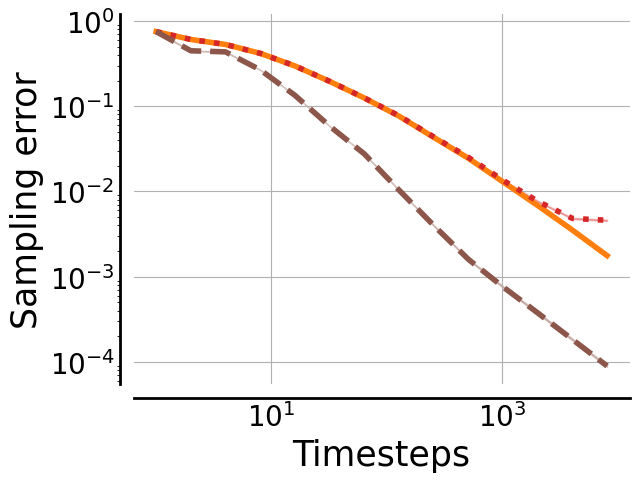

In [5]:
# Figure 6(a)
os_data = load_pickle_data('data/bandit/MultiBandit_5000_OnPolicySampler1_WeightedRegressionImportanceSampling')
os_x = os_data['eval_steps']
os_kl = np.array(os_data['kl_divergence']['OnPolicySampler'])

bpg_wis_data = load_pickle_data('data/bandit/MultiBandit_5000_BehaviorPolicyGradient2_WeightedRegressionImportanceSampling')
bpg_x = bpg_wis_data['eval_steps']
bpg_kl = np.array(bpg_wis_data['kl_divergence']['BehaviorPolicyGradient'])

ros_wis_data = load_pickle_data('data/bandit/MultiBandit_5000_RobustOnPolicySampler3_WeightedRegressionImportanceSampling')
ros_x = ros_wis_data['eval_steps']
ros_kl = np.array(ros_wis_data['kl_divergence']['RobustOnPolicySampler'])

fig_6a_plot = {
    'OS': (os_x, os_kl, COLORS[1], "-"),
    'BPG': (bpg_x, bpg_kl, COLORS[3], ":"),
    'ROS': (ros_x, ros_kl, COLORS[5], "--"),
}
draw_mean_kl(
    fig_6a_plot,
    save_figure='appendix_figures/figure6a.pdf',
    export_legend_path='appendix_figures/figure6_legend.pdf'
)

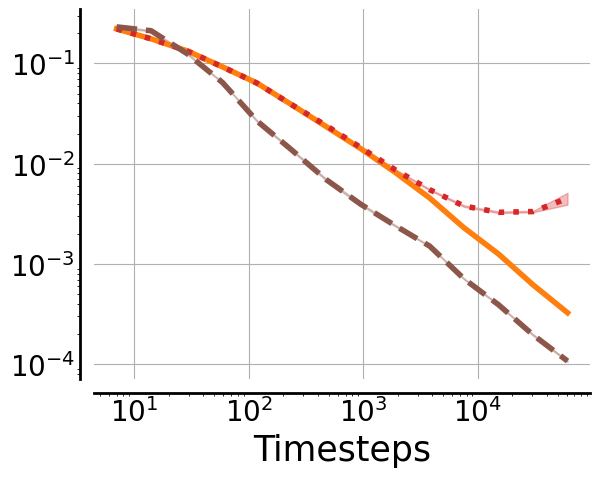

In [6]:
# Figure 6(b)
os_data = load_pickle_data('data/Gridworld/GridWorld_5000_OnPolicySampler1_WeightedRegressionImportanceSampling')
os_x = os_data['eval_steps']
os_kl = np.array(os_data['kl_divergence']['OnPolicySampler'])

bpg_data = load_pickle_data('data/Gridworld/GridWorld_5000_BehaviorPolicyGradient2_RegressionImportanceSampling')
bpg_x = bpg_data['eval_steps']
bpg_kl = np.array(bpg_data['kl_divergence']['BehaviorPolicyGradient'])

ros_data = load_pickle_data('data/Gridworld/GridWorld_5000_RobustOnPolicySampler3_RegressionImportanceSampling')
ros_x = ros_data['eval_steps']
ros_kl = np.array(ros_data['kl_divergence']['RobustOnPolicySampler'])

fig_6b_plot = {
    'OS': (os_x, os_kl, COLORS[1], "-"),
    'BPG': (bpg_x, bpg_kl, COLORS[3], ":"),
    'ROS': (ros_x, ros_kl, COLORS[5], "--"),
}
draw_mean_kl(
    fig_6b_plot,
    save_figure='appendix_figures/figure6b.pdf',
    show_y_label=False,
    plot_legend=False,
)

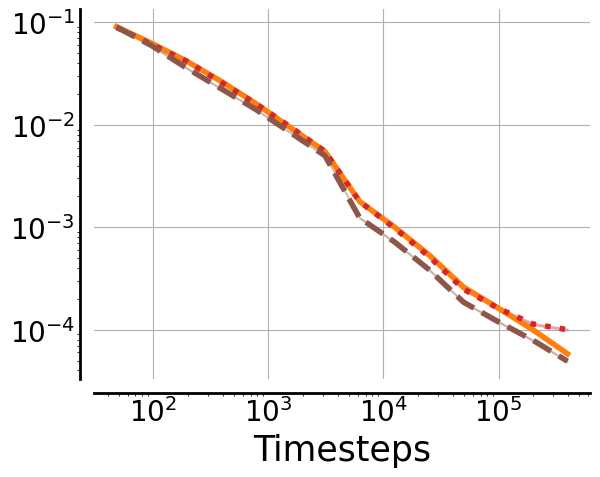

In [7]:
# Figure 6(c)
os_data = load_pickle_data('data/cartpole/CartPole_1000_OnPolicySampler1_WeightedRegressionImportanceSampling')
os_x = os_data['eval_steps']
os_kl = np.array(os_data['kl_divergence']['OnPolicySampler'])

bpg_data = load_pickle_data('data/cartpole/CartPole_1000_BehaviorPolicyGradient3_WeightedRegressionImportanceSampling')
bpg_x = bpg_data['eval_steps']
bpg_kl = np.array(bpg_data['kl_divergence']['BehaviorPolicyGradient'])

ros_data = load_pickle_data('data/cartpole/CartPole_1000_RobustOnPolicySampler2_WeightedRegressionImportanceSampling')
ros_x = ros_data['eval_steps']
ros_kl = np.array(ros_data['kl_divergence']['RobustOnPolicySampler'])

fig_6c_plot = {
    'OS': (os_x, os_kl, COLORS[1], "-"),
    'BPG': (bpg_x, bpg_kl, COLORS[3], ":"),
    'ROS': (ros_x, ros_kl, COLORS[5], "--"),
}
draw_mean_kl(
    fig_6c_plot,
    save_figure='appendix_figures/figure6c.pdf',
    show_y_label=False,
    plot_legend=False,
)

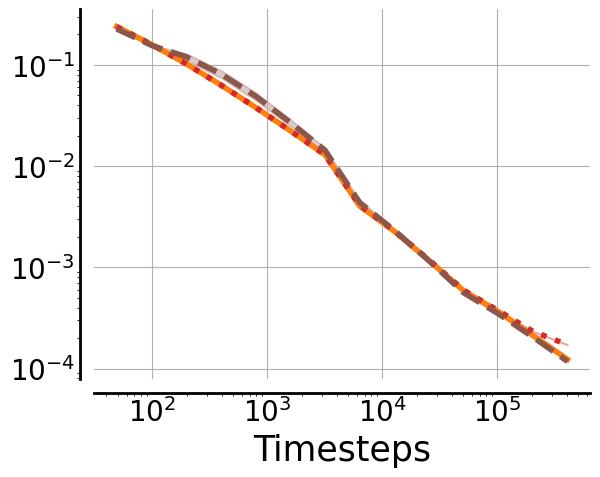

In [8]:
# Figure 6(d)
os_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_OnPolicySampler1_WeightedRegressionImportanceSampling')
os_x = os_data['eval_steps']
os_kl = np.array(os_data['kl_divergence']['OnPolicySampler'])

bpg_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_BehaviorPolicyGradient5_WeightedRegressionImportanceSampling')
bpg_x = bpg_data['eval_steps']
bpg_kl = np.array(bpg_data['kl_divergence']['BehaviorPolicyGradient'])

ros_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_RobustOnPolicySampler2_RegressionImportanceSampling')
ros_x = ros_data['eval_steps']
ros_kl = np.array(ros_data['kl_divergence']['RobustOnPolicySampler'])

fig_6d_plot = {
    'OS': (os_x, os_kl, COLORS[1], "-"),
    'BPG': (bpg_x, bpg_kl, COLORS[3], ":"),
    'ROS': (ros_x, ros_kl, COLORS[5], "--"),
}
draw_mean_kl(
    fig_6d_plot,
    save_figure='appendix_figures/figure6d.pdf',
    show_y_label=False,
    plot_legend=False,
)

<Figure size 640x480 with 0 Axes>

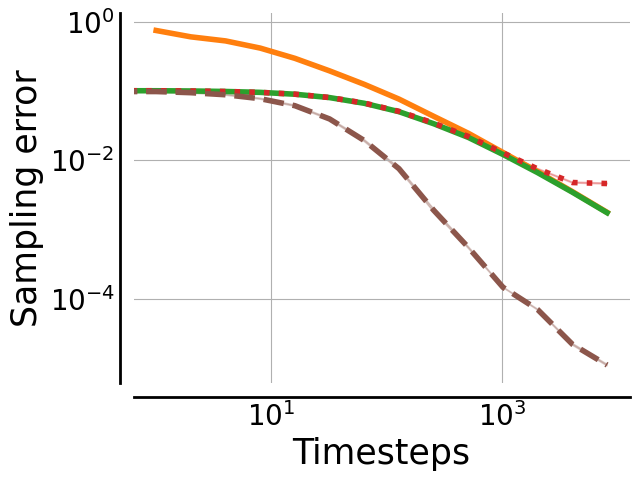

In [9]:
# Figure 7(a)
os_data = load_pickle_data('data/bandit/MultiBandit_5000_OnPolicySampler1_WeightedRegressionImportanceSampling')
os_x = os_data['eval_steps']
os_kl = np.array(os_data['kl_divergence']['OnPolicySampler'])

bpg_os_data = load_pickle_data('data/bandit/MultiBandit_5000_OnPolicySamplerComb3_WeightedRegressionImportanceSampling')
bpg_os_x = bpg_os_data['eval_steps']
bpg_os_kl = np.array(bpg_os_data['kl_divergence']['OnPolicySampler'])

bpg_wis_data = load_pickle_data('data/bandit/MultiBandit_5000_BehaviorPolicyGradientComb3_WeightedRegressionImportanceSampling')
bpg_x = bpg_wis_data['eval_steps']
bpg_kl = np.array(bpg_wis_data['kl_divergence']['BehaviorPolicyGradient'])

bpg_ros_wis_data = load_pickle_data('data/bandit/MultiBandit_5000_RobustOnPolicySamplerComb3_WeightedRegressionImportanceSampling')
bpg_ros_x = bpg_ros_wis_data['eval_steps']
bpg_ros_kl = np.array(bpg_ros_wis_data['kl_divergence']['RobustOnPolicySampler'])

fig_7a_plot = {
    'OS': (os_x, os_kl, COLORS[1], "-"),
    'OPD+OS': (bpg_os_x, bpg_os_kl, COLORS[2], "-"),
    'OPD+BPG': (bpg_x, bpg_kl, COLORS[3], ":"),
    '(OPD+ROS)-MC': (bpg_ros_x, bpg_ros_kl, COLORS[5], "--"),
}
draw_mean_kl(
    fig_7a_plot,
    save_figure='appendix_figures/figure7a.pdf',
    export_legend_path='appendix_figures/figure7_legend.pdf'
)

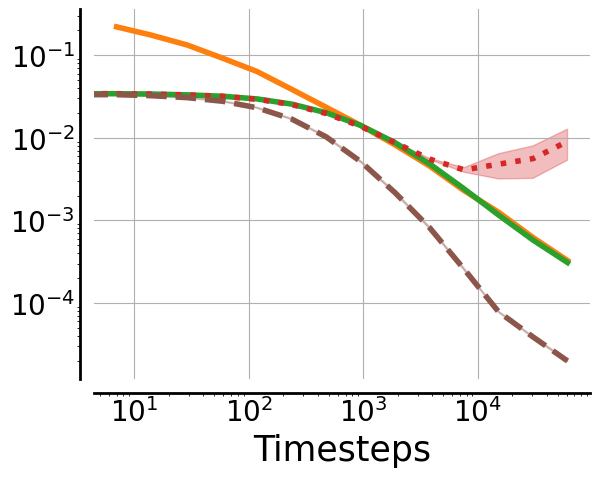

In [10]:
# Figure 7(b)
os_data = load_pickle_data('data/Gridworld/GridWorld_5000_OnPolicySampler1_WeightedRegressionImportanceSampling')
os_x = os_data['eval_steps']
os_kl = np.array(os_data['kl_divergence']['OnPolicySampler'])

bpg_os_data = load_pickle_data('data/Gridworld/GridWorld_5000_OnPolicySamplerComb3_WeightedRegressionImportanceSampling')
bpg_os_x = bpg_os_data['eval_steps']
bpg_os_kl = np.array(bpg_os_data['kl_divergence']['OnPolicySampler'])

bpg_wis_data = load_pickle_data('data/Gridworld/GridWorld_5000_BehaviorPolicyGradientComb3_WeightedRegressionImportanceSampling')
bpg_x = bpg_wis_data['eval_steps']
bpg_kl = np.array(bpg_wis_data['kl_divergence']['BehaviorPolicyGradient'])

bpg_ros_wis_data = load_pickle_data('data/Gridworld/GridWorld_5000_RobustOnPolicySamplerComb3_WeightedRegressionImportanceSampling')
bpg_ros_x = bpg_ros_wis_data['eval_steps']
bpg_ros_kl = np.array(bpg_ros_wis_data['kl_divergence']['RobustOnPolicySampler'])

fig_7b_plot = {
    'OS': (os_x, os_kl, COLORS[1], "-"),
    'OPD+OS': (bpg_os_x, bpg_os_kl, COLORS[2], "-"),
    'OPD+BPG': (bpg_x, bpg_kl, COLORS[3], ":"),
    '(OPD+ROS)-MC': (bpg_ros_x, bpg_ros_kl, COLORS[5], "--"),
}
draw_mean_kl(
    fig_7b_plot,
    save_figure='appendix_figures/figure7b.pdf',
    show_y_label=False,
    plot_legend=False,
)

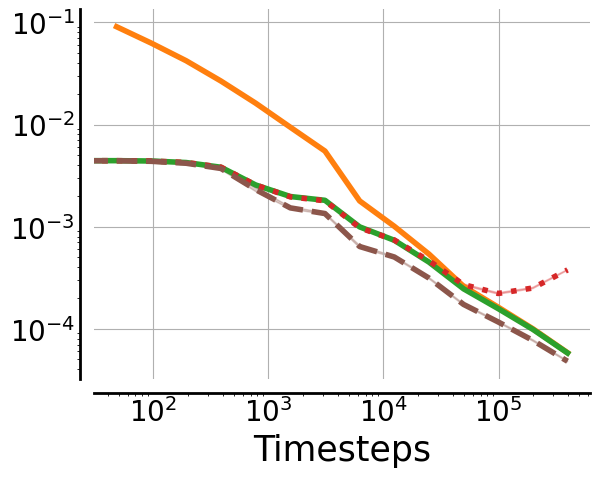

In [11]:
# Figure 7(c)
os_data = load_pickle_data('data/cartpole/CartPole_1000_OnPolicySampler1_WeightedRegressionImportanceSampling')
os_x = os_data['eval_steps']
os_kl = np.array(os_data['kl_divergence']['OnPolicySampler'])

bpg_os_data = load_pickle_data('data/cartpole/CartPole_1000_OnPolicySamplerComb3_WeightedRegressionImportanceSampling')
bpg_os_x = bpg_os_data['eval_steps']
bpg_os_kl = np.array(bpg_os_data['kl_divergence']['OnPolicySampler'])

bpg_wis_data = load_pickle_data('data/cartpole/CartPole_1000_BehaviorPolicyGradientComb3_WeightedRegressionImportanceSampling')
bpg_x = bpg_wis_data['eval_steps']
bpg_kl = np.array(bpg_wis_data['kl_divergence']['BehaviorPolicyGradient'])

bpg_ros_wis_data = load_pickle_data('data/cartpole/CartPole_1000_RobustOnPolicySamplerComb3_WeightedRegressionImportanceSampling')
bpg_ros_x = bpg_ros_wis_data['eval_steps']
bpg_ros_kl = np.array(bpg_ros_wis_data['kl_divergence']['RobustOnPolicySampler'])

fig_7c_plot = {
    'OS': (os_x, os_kl, COLORS[1], "-"),
    'OPD+OS': (bpg_os_x, bpg_os_kl, COLORS[2], "-"),
    'OPD+BPG': (bpg_x, bpg_kl, COLORS[3], ":"),
    '(OPD+ROS)-MC': (bpg_ros_x, bpg_ros_kl, COLORS[5], "--"),
}
draw_mean_kl(
    fig_7c_plot,
    save_figure='appendix_figures/figure7c.pdf',
    show_y_label=False,
    plot_legend=False,
)

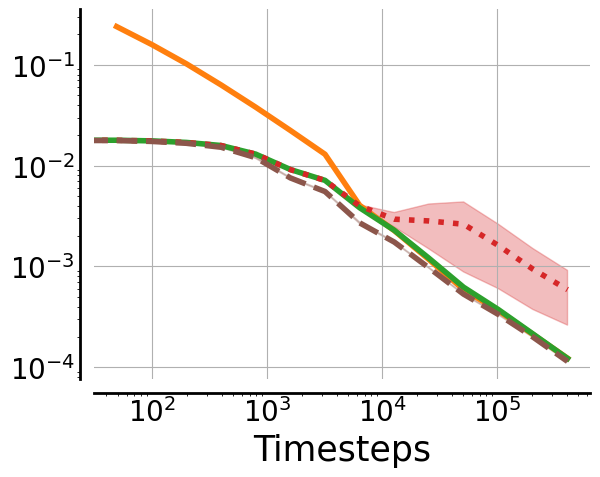

In [12]:
# Figure 7(d)
os_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_OnPolicySampler1_WeightedRegressionImportanceSampling')
os_x = os_data['eval_steps']
os_kl = np.array(os_data['kl_divergence']['OnPolicySampler'])

bpg_os_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_OnPolicySamplerComb3_WeightedRegressionImportanceSampling')
bpg_os_x = bpg_os_data['eval_steps']
bpg_os_kl = np.array(bpg_os_data['kl_divergence']['OnPolicySampler'])

bpg_wis_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_BehaviorPolicyGradientComb3_WeightedRegressionImportanceSampling')
bpg_x = bpg_wis_data['eval_steps']
bpg_kl = np.array(bpg_wis_data['kl_divergence']['BehaviorPolicyGradient'])

bpg_ros_wis_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_RobustOnPolicySamplerComb3_WeightedRegressionImportanceSampling')
bpg_ros_x = bpg_ros_wis_data['eval_steps']
bpg_ros_kl = np.array(bpg_ros_wis_data['kl_divergence']['RobustOnPolicySampler'])

fig_7d_plot = {
    'OS': (os_x, os_kl, COLORS[1], "-"),
    'OPD+OS': (bpg_os_x, bpg_os_kl, COLORS[2], "-"),
    'OPD+BPG': (bpg_x, bpg_kl, COLORS[3], ":"),
    '(OPD+ROS)-MC': (bpg_ros_x, bpg_ros_kl, COLORS[5], "--"),
}
draw_mean_kl(
    fig_7d_plot,
    save_figure='appendix_figures/figure7d.pdf',
    show_y_label=False,
    plot_legend=False,
)

<Figure size 640x480 with 0 Axes>

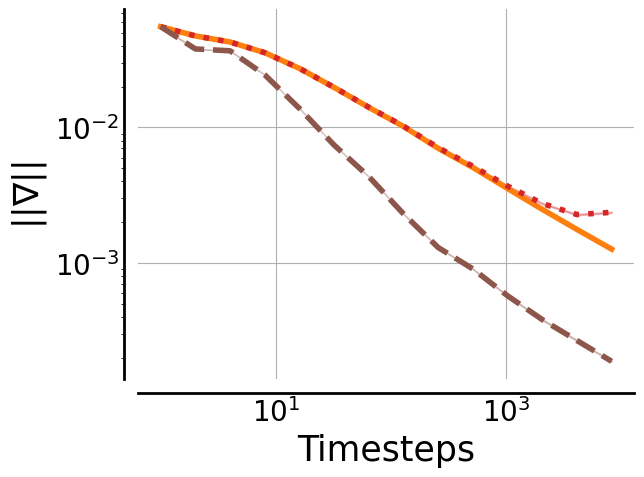

In [13]:
# Figure 8(a)
os_data = load_pickle_data('data/bandit/MultiBandit_5000_OnPolicySampler1_WeightedRegressionImportanceSampling')
os_x = os_data['eval_steps']
os_kl = np.array(os_data['avg_grad']['OnPolicySampler'])

bpg_data = load_pickle_data('data/bandit/MultiBandit_5000_BehaviorPolicyGradient2_WeightedRegressionImportanceSampling')
bpg_x = bpg_data['eval_steps']
bpg_kl = np.array(bpg_data['avg_grad']['BehaviorPolicyGradient'])

ros_data = load_pickle_data('data/bandit/MultiBandit_5000_RobustOnPolicySampler3_WeightedRegressionImportanceSampling')
ros_x = ros_data['eval_steps']
ros_kl = np.array(ros_data['avg_grad']['RobustOnPolicySampler'])

fig_8a_plot = {
    'OS': (os_x, os_kl, COLORS[1], "-"),
    'BPG': (bpg_x, bpg_kl, COLORS[3], ":"),
    'ROS': (ros_x, ros_kl, COLORS[5], "--"),
}
draw_l1(
    fig_8a_plot,
    save_figure='appendix_figures/figure8a.pdf',
    export_legend_path='appendix_figures/figure8_legend.pdf'
)

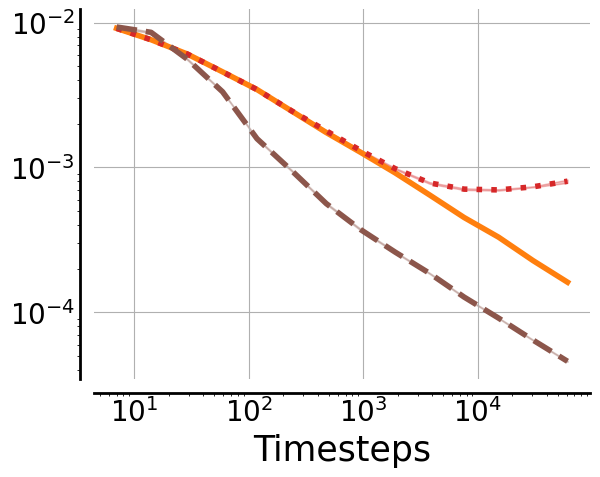

In [14]:
# Figure 8(b)
os_data = load_pickle_data('data/Gridworld/GridWorld_5000_OnPolicySampler1_WeightedRegressionImportanceSampling')
os_x = os_data['eval_steps']
os_kl = np.array(os_data['avg_grad']['OnPolicySampler'])

bpg_data = load_pickle_data('data/Gridworld/GridWorld_5000_BehaviorPolicyGradient2_RegressionImportanceSampling')
bpg_x = bpg_data['eval_steps']
bpg_kl = np.array(bpg_data['avg_grad']['BehaviorPolicyGradient'])

ros_data = load_pickle_data('data/Gridworld/GridWorld_5000_RobustOnPolicySampler3_RegressionImportanceSampling')
ros_x = ros_data['eval_steps']
ros_kl = np.array(ros_data['avg_grad']['RobustOnPolicySampler'])

fig_8b_plot = {
    'OS': (os_x, os_kl, COLORS[1], "-"),
    'BPG': (bpg_x, bpg_kl, COLORS[3], ":"),
    'ROS': (ros_x, ros_kl, COLORS[5], "--"),
}
draw_l1(
    fig_8b_plot,
    save_figure='appendix_figures/figure8b.pdf',
    show_y_label=False,
    plot_legend=False,
)

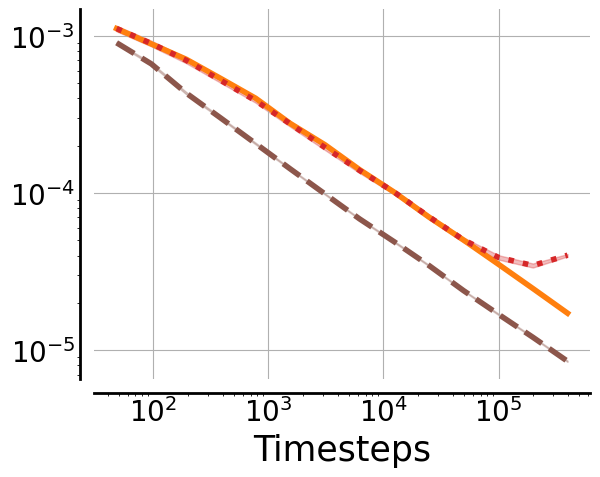

In [15]:
# Figure 8(c)
os_data = load_pickle_data('data/cartpole/CartPole_1000_OnPolicySampler1_WeightedRegressionImportanceSampling')
os_x = os_data['eval_steps']
os_kl = np.array(os_data['avg_grad']['OnPolicySampler'])

bpg_data = load_pickle_data('data/cartpole/CartPole_1000_BehaviorPolicyGradient3_WeightedRegressionImportanceSampling')
bpg_x = bpg_data['eval_steps']
bpg_kl = np.array(bpg_data['avg_grad']['BehaviorPolicyGradient'])

ros_data = load_pickle_data('data/cartpole/CartPole_1000_RobustOnPolicySampler2_WeightedRegressionImportanceSampling')
ros_x = ros_data['eval_steps']
ros_kl = np.array(ros_data['avg_grad']['RobustOnPolicySampler'])

fig_8c_plot = {
    'OS': (os_x, os_kl, COLORS[1], "-"),
    'BPG': (bpg_x, bpg_kl, COLORS[3], ":"),
    'ROS': (ros_x, ros_kl, COLORS[5], "--"),
}
draw_l1(
    fig_8c_plot,
    save_figure='appendix_figures/figure8c.pdf',
    show_y_label=False,
    plot_legend=False,
)

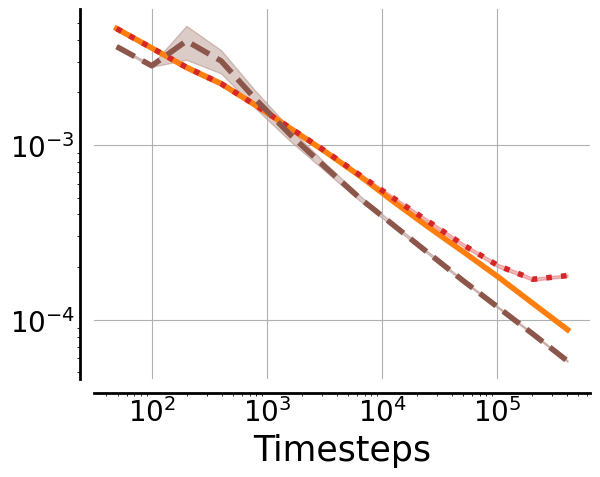

In [16]:
# Figure 8(d)
os_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_OnPolicySampler1_WeightedRegressionImportanceSampling')
os_x = os_data['eval_steps']
os_kl = np.array(os_data['avg_grad']['OnPolicySampler'])

bpg_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_BehaviorPolicyGradient5_WeightedRegressionImportanceSampling')
bpg_x = bpg_data['eval_steps']
bpg_kl = np.array(bpg_data['avg_grad']['BehaviorPolicyGradient'])

ros_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_RobustOnPolicySampler2_RegressionImportanceSampling')
ros_x = ros_data['eval_steps']
ros_kl = np.array(ros_data['avg_grad']['RobustOnPolicySampler'])

fig_8d_plot = {
    'OS': (os_x, os_kl, COLORS[1], "-"),
    'BPG': (bpg_x, bpg_kl, COLORS[3], ":"),
    'ROS': (ros_x, ros_kl, COLORS[5], "--"),
}
draw_l1(
    fig_8d_plot,
    save_figure='appendix_figures/figure8d.pdf',
    show_y_label=False,
    plot_legend=False,
)

<Figure size 640x480 with 0 Axes>

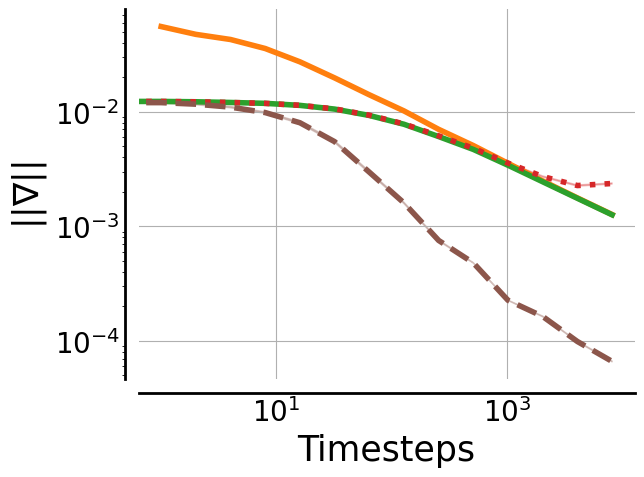

In [17]:
# Figure 9(a)
os_data = load_pickle_data('data/bandit/MultiBandit_5000_OnPolicySampler1_WeightedRegressionImportanceSampling')
os_x = os_data['eval_steps']
os_kl = np.array(os_data['avg_grad']['OnPolicySampler'])

bpg_os_data = load_pickle_data('data/bandit/MultiBandit_5000_OnPolicySamplerComb3_WeightedRegressionImportanceSampling')
bpg_os_x = bpg_os_data['eval_steps']
bpg_os_kl = np.array(bpg_os_data['avg_grad']['OnPolicySampler'])

bpg_wis_data = load_pickle_data('data/bandit/MultiBandit_5000_BehaviorPolicyGradientComb3_WeightedRegressionImportanceSampling')
bpg_x = bpg_wis_data['eval_steps']
bpg_kl = np.array(bpg_wis_data['avg_grad']['BehaviorPolicyGradient'])

bpg_ros_wis_data = load_pickle_data('data/bandit/MultiBandit_5000_RobustOnPolicySamplerComb3_WeightedRegressionImportanceSampling')
bpg_ros_x = bpg_ros_wis_data['eval_steps']
bpg_ros_kl = np.array(bpg_ros_wis_data['avg_grad']['RobustOnPolicySampler'])

fig_9a_plot = {
    'OS': (os_x, os_kl, COLORS[1], "-"),
    'OPD+OS': (bpg_os_x, bpg_os_kl, COLORS[2], "-"),
    'OPD+BPG': (bpg_x, bpg_kl, COLORS[3], ":"),
    '(OPD+ROS)-MC': (bpg_ros_x, bpg_ros_kl, COLORS[5], "--"),
}
draw_l1(
    fig_9a_plot,
    save_figure='appendix_figures/figure9a.pdf',
    export_legend_path='appendix_figures/figure9_legend.pdf'
)

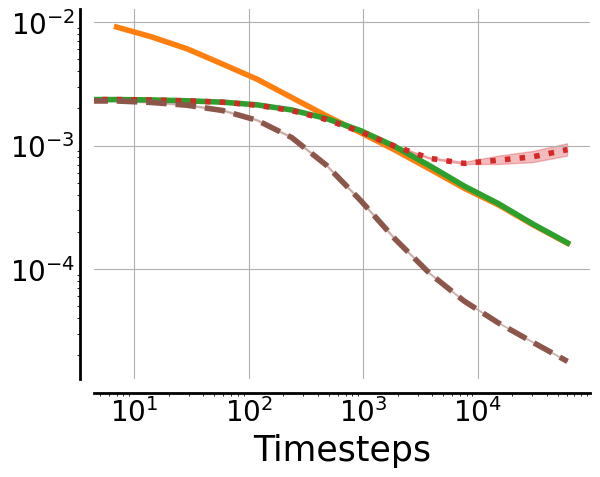

In [18]:
# Figure 9(b)
os_data = load_pickle_data('data/Gridworld/GridWorld_5000_OnPolicySampler1_WeightedRegressionImportanceSampling')
os_x = os_data['eval_steps']
os_kl = np.array(os_data['avg_grad']['OnPolicySampler'])

bpg_os_data = load_pickle_data('data/Gridworld/GridWorld_5000_OnPolicySamplerComb3_WeightedRegressionImportanceSampling')
bpg_os_x = bpg_os_data['eval_steps']
bpg_os_kl = np.array(bpg_os_data['avg_grad']['OnPolicySampler'])

bpg_wis_data = load_pickle_data('data/Gridworld/GridWorld_5000_BehaviorPolicyGradientComb3_WeightedRegressionImportanceSampling')
bpg_x = bpg_wis_data['eval_steps']
bpg_kl = np.array(bpg_wis_data['avg_grad']['BehaviorPolicyGradient'])

bpg_ros_wis_data = load_pickle_data('data/Gridworld/GridWorld_5000_RobustOnPolicySamplerComb3_WeightedRegressionImportanceSampling')
bpg_ros_x = bpg_ros_wis_data['eval_steps']
bpg_ros_kl = np.array(bpg_ros_wis_data['avg_grad']['RobustOnPolicySampler'])

fig_9b_plot = {
    'OS': (os_x, os_kl, COLORS[1], "-"),
    'OPD+OS': (bpg_os_x, bpg_os_kl, COLORS[2], "-"),
    'OPD+BPG': (bpg_x, bpg_kl, COLORS[3], ":"),
    '(OPD+ROS)-MC': (bpg_ros_x, bpg_ros_kl, COLORS[5], "--"),
}
draw_l1(
    fig_9b_plot,
    save_figure='appendix_figures/figure9b.pdf',
    show_y_label=False,
    plot_legend=False,
)

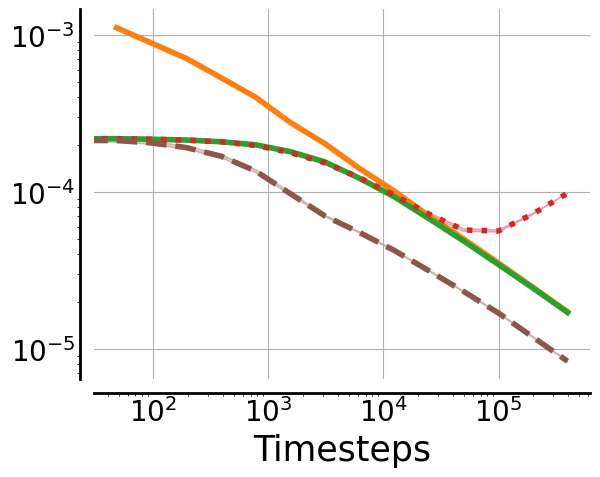

In [19]:
# Figure 9(c)
os_data = load_pickle_data('data/cartpole/CartPole_1000_OnPolicySampler1_WeightedRegressionImportanceSampling')
os_x = os_data['eval_steps']
os_kl = np.array(os_data['avg_grad']['OnPolicySampler'])

bpg_os_data = load_pickle_data('data/cartpole/CartPole_1000_OnPolicySamplerComb3_WeightedRegressionImportanceSampling')
bpg_os_x = bpg_os_data['eval_steps']
bpg_os_kl = np.array(bpg_os_data['avg_grad']['OnPolicySampler'])

bpg_wis_data = load_pickle_data('data/cartpole/CartPole_1000_BehaviorPolicyGradientComb3_WeightedRegressionImportanceSampling')
bpg_x = bpg_wis_data['eval_steps']
bpg_kl = np.array(bpg_wis_data['avg_grad']['BehaviorPolicyGradient'])

bpg_ros_wis_data = load_pickle_data('data/cartpole/CartPole_1000_RobustOnPolicySamplerComb3_WeightedRegressionImportanceSampling')
bpg_ros_x = bpg_ros_wis_data['eval_steps']
bpg_ros_kl = np.array(bpg_ros_wis_data['avg_grad']['RobustOnPolicySampler'])

fig_9c_plot = {
    'OS': (os_x, os_kl, COLORS[1], "-"),
    'OPD+OS': (bpg_os_x, bpg_os_kl, COLORS[2], "-"),
    'OPD+BPG': (bpg_x, bpg_kl, COLORS[3], ":"),
    '(OPD+ROS)-MC': (bpg_ros_x, bpg_ros_kl, COLORS[5], "--"),
}
draw_l1(
    fig_9c_plot,
    save_figure='appendix_figures/figure9c.pdf',
    show_y_label=False,
    plot_legend=False,
)

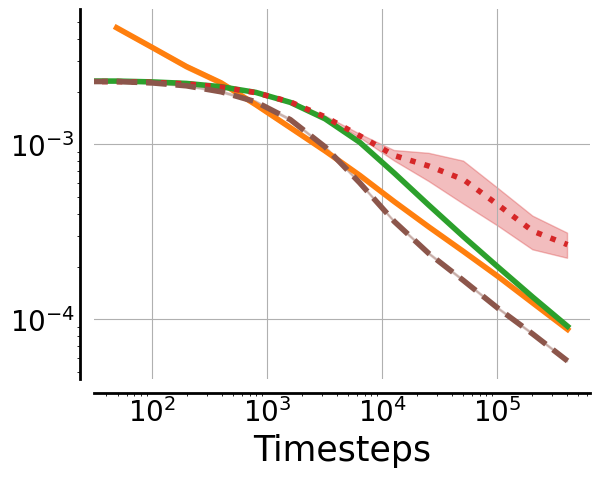

In [20]:
# Figure 9(d)
os_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_OnPolicySampler1_WeightedRegressionImportanceSampling')
os_x = os_data['eval_steps']
os_kl = np.array(os_data['avg_grad']['OnPolicySampler'])

bpg_os_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_OnPolicySamplerComb3_WeightedRegressionImportanceSampling')
bpg_os_x = bpg_os_data['eval_steps']
bpg_os_kl = np.array(bpg_os_data['avg_grad']['OnPolicySampler'])

bpg_wis_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_BehaviorPolicyGradientComb3_WeightedRegressionImportanceSampling')
bpg_x = bpg_wis_data['eval_steps']
bpg_kl = np.array(bpg_wis_data['avg_grad']['BehaviorPolicyGradient'])

bpg_ros_wis_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_RobustOnPolicySamplerComb3_WeightedRegressionImportanceSampling')
bpg_ros_x = bpg_ros_wis_data['eval_steps']
bpg_ros_kl = np.array(bpg_ros_wis_data['avg_grad']['RobustOnPolicySampler'])

fig_9d_plot = {
    'OS': (os_x, os_kl, COLORS[1], "-"),
    'OPD+OS': (bpg_os_x, bpg_os_kl, COLORS[2], "-"),
    'OPD+BPG': (bpg_x, bpg_kl, COLORS[3], ":"),
    '(OPD+ROS)-MC': (bpg_ros_x, bpg_ros_kl, COLORS[5], "--"),
}
draw_l1(
    fig_9d_plot,
    save_figure='appendix_figures/figure9d.pdf',
    show_y_label=False,
    plot_legend=False,
)

<Figure size 640x480 with 0 Axes>

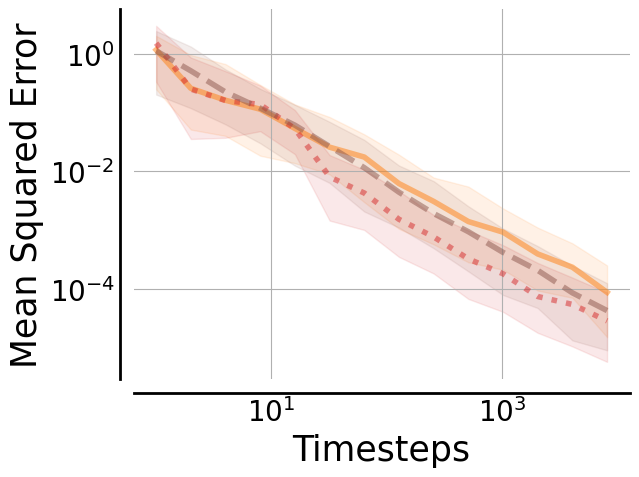

In [21]:
# Figure 10(a) 
figure_2a_data = torch.load('data/bandit/figure2a.pt')
x = figure_2a_data['xx']
values1 = figure_2a_data['values1']
values2 = figure_2a_data['values2']
values3 = figure_2a_data['values3']

fig_10a_plot = {
    'OS-MC': (x, values1, COLORS[1], '-'),
    'BPG-OIS': (x, values2, COLORS[3], ':'),
    'ROS-MC': (x, values3, COLORS[5], '--'),
    
}
draw_quantile(
    fig_10a_plot,
    save_figure='appendix_figures/figure10a.pdf',
    export_legend_path='appendix_figures/figure10_legend.pdf'
)

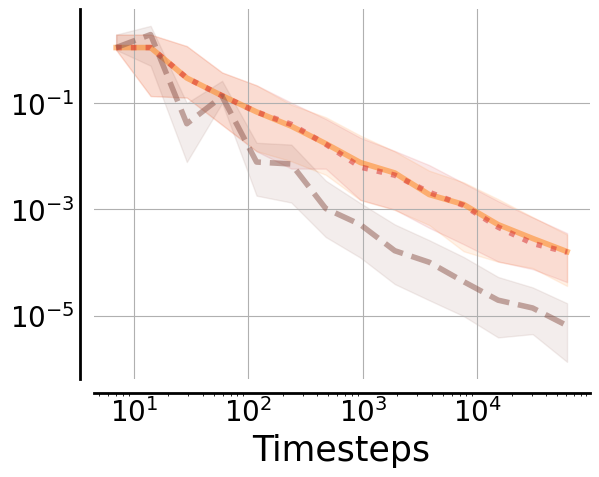

In [22]:
# Figure 10(b)
fig_2c_os_data = load_pickle_data('data/Gridworld/GridWorld_5000_OnPolicySampler1_MonteCarlo')
os_x = fig_2c_os_data['eval_steps']
values = np.array(fig_2c_os_data['estimations'][('OnPolicySampler','MonteCarlo')]) 
os_values = (values-1)**2

fig_2c_bpg_data = load_pickle_data('data/Gridworld/GridWorld_5000_BehaviorPolicyGradient2_OrdinaryImportanceSampling')
bpg_x = fig_2c_bpg_data['eval_steps']
values = np.array(fig_2c_bpg_data['estimations'][('BehaviorPolicyGradient', 'OrdinaryImportanceSampling')])
bpg_values = (values-1)**2

fig_2c_ros_data = load_pickle_data('data/Gridworld/GridWorld_5000_RobustOnPolicySampler3_MonteCarlo')
ros_x = fig_2c_ros_data['eval_steps']
values = np.array(fig_2c_ros_data['estimations'][('RobustOnPolicySampler', 'MonteCarlo')])
ros_values = (values-1)**2

fig_10b_plot = {
    'OS-MC': (os_x, os_values, COLORS[1], '-'),
    'BPG-OIS': (bpg_x, bpg_values, COLORS[3], ':'),
    'ROS-MC': (ros_x, ros_values, COLORS[5], '--'),
    
}
draw_quantile(
    fig_10b_plot,
    save_figure='appendix_figures/figure10b.pdf',
    show_y_label=False,
    plot_legend=False,
)

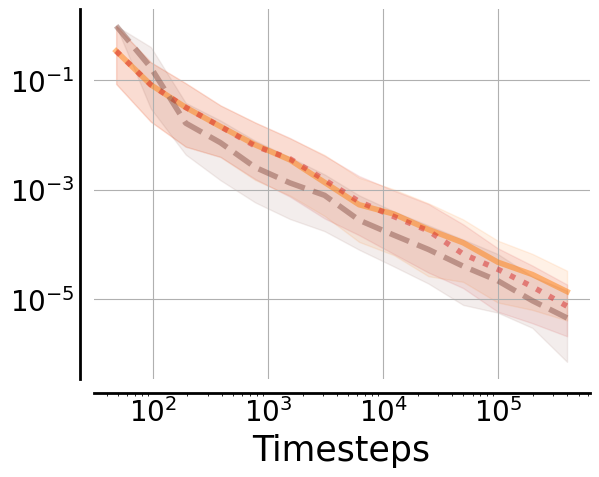

In [23]:
# Figure 10(c)
fig_2c_os_data = load_pickle_data('data/cartpole/CartPole_1000_OnPolicySampler1_MonteCarlo')
os_x = fig_2c_os_data['eval_steps']
values = np.array(fig_2c_os_data['estimations'][('OnPolicySampler','MonteCarlo')]) 
os_values = (values-1)**2

fig_2c_bpg_data = load_pickle_data('data/cartpole/CartPole_1000_BehaviorPolicyGradient1_OrdinaryImportanceSampling')
bpg_x = fig_2c_bpg_data['eval_steps']
values = np.array(fig_2c_bpg_data['estimations'][('BehaviorPolicyGradient', 'OrdinaryImportanceSampling')])
bpg_values = (values-1)**2

fig_2c_ros_data = load_pickle_data('data/cartpole/CartPole_1000_RobustOnPolicySampler2_MonteCarlo')
ros_x = fig_2c_ros_data['eval_steps']
values = np.array(fig_2c_ros_data['estimations'][('RobustOnPolicySampler', 'MonteCarlo')])
ros_values = (values-1)**2

fig_10c_plot = {
    'OS-MC': (os_x, os_values, COLORS[1], '-'),
    'BPG-OIS': (bpg_x, bpg_values, COLORS[3], ':'),
    'ROS-MC': (ros_x, ros_values, COLORS[5], '--'),
    
}
draw_quantile(
    fig_10c_plot,
    save_figure='appendix_figures/figure10c.pdf',
    show_y_label=False,
    plot_legend=False,
)

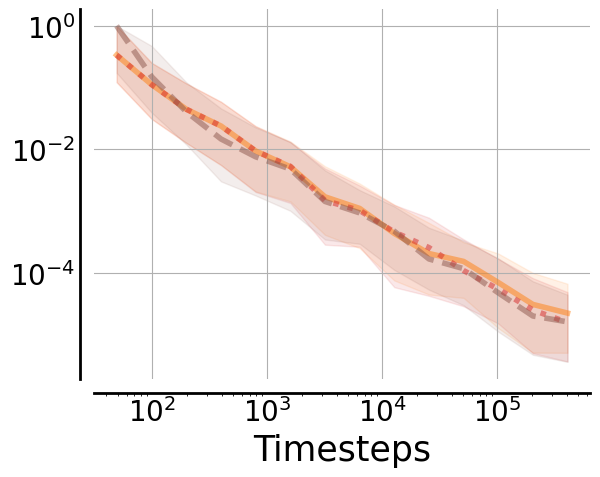

In [24]:
# Figure 10(d)
fig_2c_os_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_OnPolicySampler1_MonteCarlo')
os_x = fig_2c_os_data['eval_steps']
values = np.array(fig_2c_os_data['estimations'][('OnPolicySampler','MonteCarlo')]) 
os_values = (values-1)**2

fig_2c_bpg_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_BehaviorPolicyGradient5_OrdinaryImportanceSampling')
bpg_x = fig_2c_bpg_data['eval_steps']
values = np.array(fig_2c_bpg_data['estimations'][('BehaviorPolicyGradient', 'OrdinaryImportanceSampling')])
bpg_values = (values-1)**2

fig_2c_ros_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_RobustOnPolicySampler2_MonteCarlo')
ros_x = fig_2c_ros_data['eval_steps']
values = np.array(fig_2c_ros_data['estimations'][('RobustOnPolicySampler', 'MonteCarlo')])
ros_values = (values-1)**2

fig_10d_plot = {
    'OS-MC': (os_x, os_values, COLORS[1], '-'),
    'BPG-OIS': (bpg_x, bpg_values, COLORS[3], ':'),
    'ROS-MC': (ros_x, ros_values, COLORS[5], '--'),
    
}
draw_quantile(
    fig_10d_plot,
    save_figure='appendix_figures/figure10d.pdf',
    show_y_label=False,
    plot_legend=False,
)

<Figure size 640x480 with 0 Axes>

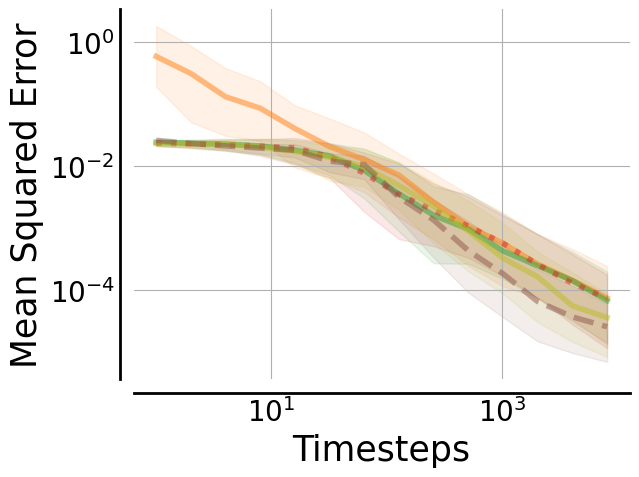

In [25]:
# Figure 11(a)
figure3a_data = torch.load('data/bandit/figure3a.pt')
x = figure3a_data['xx']
values1 = figure3a_data['values1']
values2 = figure3a_data['values2']
values3 = figure3a_data['values3']
values4 = figure3a_data['values4']
values5 = figure3a_data['values5']

fig_11a_plot = {
    'OS-MC': (x, values1, COLORS[1], '-'),
    '(OPD+OS)-MC': (x, values2, COLORS[2], '-'),
    '(OPD+BPG)-OIS': (x, values3, COLORS[3], ':'),
    '(OPD+OS)-(WIS+MC)': (x, values4, COLORS[8], '-'),
    '(OPD+ROS)-MC': (x, values5, COLORS[5], '--'),
}
draw_quantile(
    fig_11a_plot,
    save_figure='appendix_figures/figure11a.pdf',
    export_legend_path='appendix_figures/figure11_legend.pdf'
)

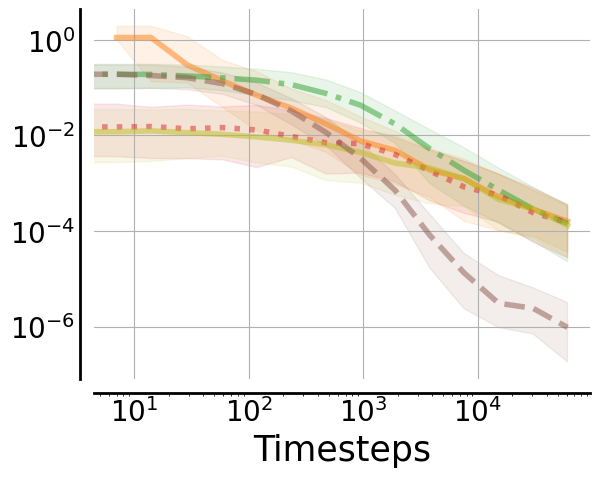

In [26]:
# Figure 11(b)
fig_os_mc_data = load_pickle_data('data/Gridworld/GridWorld_5000_OnPolicySampler1_MonteCarlo')
os_mc_x = fig_os_mc_data['eval_steps']
os_mc_values = np.array(fig_os_mc_data['estimations'][('OnPolicySampler','MonteCarlo')]) 
os_mc_values = (os_mc_values-1)**2

fig_os_opd_mc_data = load_pickle_data('data/Gridworld/GridWorld_5000_OnPolicySamplerComb3_MonteCarlo')
os_opd_mc_x = fig_os_opd_mc_data['eval_steps']
os_opd_mc_values = np.array(fig_os_opd_mc_data['estimations'][('OnPolicySampler', 'MonteCarlo')])
os_opd_mc_values = (os_opd_mc_values-1)**2

fig_bpg_ois_data = load_pickle_data('data/Gridworld/GridWorld_5000_BehaviorPolicyGradientComb3_OrdinaryImportanceSampling')
bpg_ois_x = fig_bpg_ois_data['eval_steps']
bpg_ois_values = np.array(fig_bpg_ois_data['estimations'][('BehaviorPolicyGradient', 'OrdinaryImportanceSampling')])
bpg_ois_values = (bpg_ois_values-1)**2

fig_os_pre_opd_mc_data = load_pickle_data('data/Gridworld/GridWorld_5000_OnPolicySamplerPreComb3_MonteCarlo')
os_opd_wis_mc_x = fig_os_pre_opd_mc_data['eval_steps']
os_opd_wis_mc_values = np.array(fig_os_pre_opd_mc_data['estimations'][('OnPolicySampler', 'MonteCarlo')])
os_opd_wis_mc_values = (os_opd_wis_mc_values-1)**2

fig_ros_mc_data = load_pickle_data('data/Gridworld/GridWorld_5000_RobustOnPolicySamplerComb3_MonteCarlo')
ros_mc_x = fig_ros_mc_data['eval_steps']
ros_mc_values = np.array(fig_ros_mc_data['estimations'][('RobustOnPolicySampler', 'MonteCarlo')])
ros_mc_values = (ros_mc_values-1)**2

fig_11b_plot = {
    'OS-MC': (os_mc_x, os_mc_values, COLORS[1], '-'),
    '(OPD+OS)-MC': (os_opd_mc_x, os_opd_mc_values, COLORS[2], '-.'),
    '(OPD+BPG)-OIS': (bpg_ois_x, bpg_ois_values, COLORS[3], ':'),
    '(OPD+OS)-(WIS+MC)': (os_opd_wis_mc_x, os_opd_wis_mc_values, COLORS[8], '-'),
    '(OPD+ROS)-MC': (ros_mc_x, ros_mc_values, COLORS[5], '--'),
}
draw_quantile(
    fig_11b_plot,
    save_figure='appendix_figures/figure11b.pdf',
    show_y_label=False,
    plot_legend=False,
)

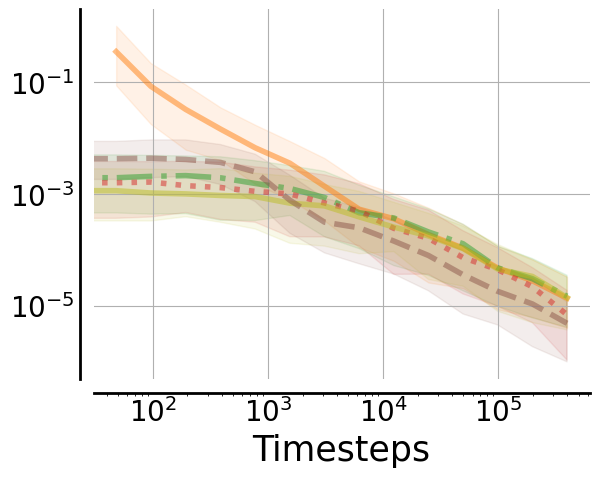

In [27]:
# Figure 11(c)
fig_os_mc_data = load_pickle_data('data/cartpole/CartPole_1000_OnPolicySampler1_MonteCarlo')
os_mc_x = fig_os_mc_data['eval_steps']
os_mc_values = np.array(fig_os_mc_data['estimations'][('OnPolicySampler','MonteCarlo')]) 
os_mc_values = (os_mc_values-1)**2

fig_os_opd_mc_data = load_pickle_data('data/cartpole/CartPole_1000_OnPolicySamplerComb2_MonteCarlo')
os_opd_mc_x = fig_os_opd_mc_data['eval_steps']
os_opd_mc_values = np.array(fig_os_opd_mc_data['estimations'][('OnPolicySampler', 'MonteCarlo')])
os_opd_mc_values = (os_opd_mc_values-1)**2

fig_bpg_ois_data = load_pickle_data('data/cartpole/CartPole_1000_BehaviorPolicyGradientComb2_OrdinaryImportanceSampling')
bpg_ois_x = fig_bpg_ois_data['eval_steps']
bpg_ois_values = np.array(fig_bpg_ois_data['estimations'][('BehaviorPolicyGradient', 'OrdinaryImportanceSampling')])
bpg_ois_values = (bpg_ois_values-1)**2

fig_os_pre_opd_mc_data = load_pickle_data('data/cartpole/CartPole_1000_OnPolicySamplerPreComb2_MonteCarlo')
os_opd_wis_mc_x = fig_os_pre_opd_mc_data['eval_steps']
os_opd_wis_mc_values = np.array(fig_os_pre_opd_mc_data['estimations'][('OnPolicySampler', 'MonteCarlo')])
os_opd_wis_mc_values = (os_opd_wis_mc_values-1)**2

fig_ros_mc_data = load_pickle_data('data/cartpole/CartPole_1000_RobustOnPolicySamplerComb3_MonteCarlo')
ros_mc_x = fig_ros_mc_data['eval_steps']
ros_mc_values = np.array(fig_ros_mc_data['estimations'][('RobustOnPolicySampler', 'MonteCarlo')])
ros_mc_values = (ros_mc_values-1)**2

fig_11c_plot = {
    'OS-MC': (os_mc_x, os_mc_values, COLORS[1], '-'),
    '(OPD+OS)-MC': (os_opd_mc_x, os_opd_mc_values, COLORS[2], '-.'),
    '(OPD+BPG)-OIS': (bpg_ois_x, bpg_ois_values, COLORS[3], ':'),
    '(OPD+OS)-(WIS+MC)': (os_opd_wis_mc_x, os_opd_wis_mc_values, COLORS[8], '-'),
    '(OPD+ROS)-MC': (ros_mc_x, ros_mc_values, COLORS[5], '--'),
}
draw_quantile(
    fig_11c_plot,
    save_figure='appendix_figures/figure11c.pdf',
    show_y_label=False,
    plot_legend=False,
)

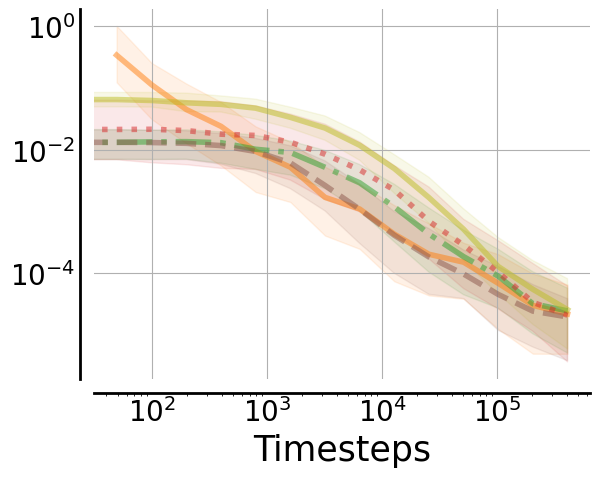

In [28]:
#Figure 11(d)
fig_os_mc_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_OnPolicySampler1_MonteCarlo')
os_mc_x = fig_os_mc_data['eval_steps']
os_mc_values = np.array(fig_os_mc_data['estimations'][('OnPolicySampler','MonteCarlo')]) 
os_mc_values = (os_mc_values-1)**2

fig_os_opd_mc_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_OnPolicySamplerComb3_MonteCarlo')
os_opd_mc_x = fig_os_opd_mc_data['eval_steps']
os_opd_mc_values = np.array(fig_os_opd_mc_data['estimations'][('OnPolicySampler', 'MonteCarlo')])
os_opd_mc_values = (os_opd_mc_values-1)**2

fig_bpg_ois_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_BehaviorPolicyGradientComb3_OrdinaryImportanceSampling')
bpg_ois_x = fig_bpg_ois_data['eval_steps']
bpg_ois_values = np.array(fig_bpg_ois_data['estimations'][('BehaviorPolicyGradient', 'OrdinaryImportanceSampling')])
bpg_ois_values = (bpg_ois_values-1)**2

fig_os_pre_opd_mc_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_OnPolicySamplerPreComb2_MonteCarlo')
os_opd_wis_mc_x = fig_os_pre_opd_mc_data['eval_steps']
os_opd_wis_mc_values = np.array(fig_os_pre_opd_mc_data['estimations'][('OnPolicySampler', 'MonteCarlo')])
os_opd_wis_mc_values = (os_opd_wis_mc_values-1)**2

fig_ros_mc_data = load_pickle_data('data/con_cartpole/CartPoleContinuous_3000_RobustOnPolicySamplerComb3_MonteCarlo')
ros_mc_x = fig_ros_mc_data['eval_steps']
ros_mc_values = np.array(fig_ros_mc_data['estimations'][('RobustOnPolicySampler', 'MonteCarlo')])
ros_mc_values = (ros_mc_values-1)**2

fig_11d_plot = {
    'OS-MC': (os_mc_x, os_mc_values, COLORS[1], '-'),
    '(OPD+OS)-MC': (os_opd_mc_x, os_opd_mc_values, COLORS[2], '-.'),
    '(OPD+BPG)-OIS': (bpg_ois_x, bpg_ois_values, COLORS[3], ':'),
    '(OPD+OS)-(WIS+MC)': (os_opd_wis_mc_x, os_opd_wis_mc_values, COLORS[8], '-'),
    '(OPD+ROS)-MC': (ros_mc_x, ros_mc_values, COLORS[5], '--'),
}
draw_quantile(
    fig_11d_plot,
    save_figure='appendix_figures/figure11d.pdf',
    show_y_label=False,
    plot_legend=False,
)

In [29]:
# Figure 12(a)
aa = np.zeros(10)
xx = np.array(range(10))+1
filer1 = 'data/Gridworld_ms/GridWorldM1S1_5000_RobustOnPolicySampler1_MonteCarlo'
aaar1 = load_pickle_data(filer1)
datr1 = np.array(aaar1['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mser1 = (datr1-1)**2

fileo1 = 'data/Gridworld_ms/GridWorldM1S1_5000_OnPolicySampler1_MonteCarlo'
aaao1 = load_pickle_data(fileo1)
dato1 = np.array(aaao1['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo1 = (dato1-1)**2

aa[1-1] = np.mean(mser1)/np.mean(mseo1)

file2 = 'data/Gridworld_ms/GridWorldM2S1_5000_RobustOnPolicySampler1_MonteCarlo'
aaa2 = load_pickle_data(file2)
dat2 = np.array(aaa2['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse2 = (dat2-1)**2

fileo2 = 'data/Gridworld_ms/GridWorldM2S1_5000_OnPolicySampler1_MonteCarlo'
aaao2 = load_pickle_data(fileo2)
dato2 = np.array(aaao2['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo2 = (dato2-1)**2

aa[2-1] = np.mean(mse2)/np.mean(mseo2)

file3 = 'data/Gridworld_ms/GridWorldM3S1_5000_RobustOnPolicySampler1_MonteCarlo'
aaa3 = load_pickle_data(file3)
dat3 = np.array(aaa3['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse3 = (dat3-1)**2

fileo3 = 'data/Gridworld_ms/GridWorldM3S1_5000_OnPolicySampler1_MonteCarlo'
aaao3 = load_pickle_data(fileo3)
dato3 = np.array(aaao3['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo3 = (dato3-1)**2

aa[3-1] = np.mean(mse3)/np.mean(mseo3)

file4 = 'data/Gridworld_ms/GridWorldM4S1_5000_RobustOnPolicySampler1_MonteCarlo'
aaa4 = load_pickle_data(file4)
dat4 = np.array(aaa4['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse4 = (dat4-1)**2

fileo4 = 'data/Gridworld_ms/GridWorldM4S1_5000_OnPolicySampler1_MonteCarlo'
aaao4 = load_pickle_data(fileo4)
dato4 = np.array(aaao4['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo4 = (dato4-1)**2

aa[4-1] = np.mean(mse4)/np.mean(mseo4)

file5 = 'data/Gridworld_ms/GridWorldM5S1_5000_RobustOnPolicySampler1_MonteCarlo'
aaa5 = load_pickle_data(file5)
dat5 = np.array(aaa5['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse5 = (dat5-1)**2

fileo5 = 'data/Gridworld_ms/GridWorldM5S1_5000_OnPolicySampler1_MonteCarlo'
aaao5 = load_pickle_data(fileo5)
dato5 = np.array(aaao5['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo5 = (dato5-1)**2

aa[5-1] = np.mean(mse5)/np.mean(mseo5)

file6 = 'data/Gridworld_ms/GridWorldM6S1_5000_RobustOnPolicySampler1_MonteCarlo'
aaa6 = load_pickle_data(file6)
dat6 = np.array(aaa6['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse6 = (dat6-1)**2

fileo6 = 'data/Gridworld_ms/GridWorldM6S1_5000_OnPolicySampler1_MonteCarlo'
aaao6 = load_pickle_data(fileo6)
dato6 = np.array(aaao6['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo6 = (dato6-1)**2

aa[6-1] = np.mean(mse6)/np.mean(mseo6)

file7 = 'data/Gridworld_ms/GridWorldM7S1_5000_RobustOnPolicySampler1_MonteCarlo'
aaa7 = load_pickle_data(file7)
dat7 = np.array(aaa7['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse7 = (dat7-1)**2

fileo7 = 'data/Gridworld_ms/GridWorldM7S1_5000_OnPolicySampler1_MonteCarlo'
aaao7 = load_pickle_data(fileo7)
dato7 = np.array(aaao7['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo7 = (dato7-1)**2

aa[7-1] = np.mean(mse7)/np.mean(mseo7)

file8 = 'data/Gridworld_ms/GridWorldM8S1_5000_RobustOnPolicySampler1_MonteCarlo'
aaa8 = load_pickle_data(file8)
dat8 = np.array(aaa8['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse8 = (dat8-1)**2

fileo8 = 'data/Gridworld_ms/GridWorldM8S1_5000_OnPolicySampler1_MonteCarlo'
aaao8 = load_pickle_data(fileo8)
dato8 = np.array(aaao8['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo8 = (dato8-1)**2

aa[8-1] = np.mean(mse8)/np.mean(mseo8)

file9 = 'data/Gridworld_ms/GridWorldM9S1_5000_RobustOnPolicySampler1_MonteCarlo'
aaa9 = load_pickle_data(file9)
dat9 = np.array(aaa9['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse9 = (dat9-1)**2

fileo9 = 'data/Gridworld_ms/GridWorldM9S1_5000_OnPolicySampler1_MonteCarlo'
aaao9 = load_pickle_data(fileo9)
dato9 = np.array(aaao9['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo9 = (dato9-1)**2

aa[9-1] = np.mean(mse9)/np.mean(mseo9)

file10 = 'data/Gridworld_ms/GridWorldM10S1_5000_RobustOnPolicySampler1_MonteCarlo'
aaa10 = load_pickle_data(file10)
dat10 = np.array(aaa10['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse10 = (dat10-1)**2

fileo10 = 'data/Gridworld_ms/GridWorldM10S1_5000_OnPolicySampler1_MonteCarlo'
aaao10 = load_pickle_data(fileo10)
dato10 = np.array(aaao10['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo10 = (dato10-1)**2

aa[10-1] = np.mean(mse10)/np.mean(mseo10)

In [30]:
bbb = np.zeros(10)
file1 = 'data/Gridworld_ms/GridWorldM1S1_5000_RobustOnPolicySampler1_MonteCarlo'
aaa1 = load_pickle_data(file1)
dat1 = np.array(aaa1['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse1 = (dat1-1)**2

fileo1 = 'data/Gridworld_ms/GridWorldM1S1_5000_OnPolicySampler1_MonteCarlo'
aaao1 = load_pickle_data(fileo1)
dato1 = np.array(aaao1['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo1 = (dato1-1)**2

bbb[1-1] = np.mean(mse1)/np.mean(mseo1)

file2 = 'data/Gridworld_ms/GridWorldM1S2_5000_RobustOnPolicySampler1_MonteCarlo'
aaa2 = load_pickle_data(file2)
dat2 = np.array(aaa2['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse2 = (dat2-1)**2

fileo2 = 'data/Gridworld_ms/GridWorldM1S2_5000_OnPolicySampler1_MonteCarlo'
aaao2 = load_pickle_data(fileo2)
dato2 = np.array(aaao2['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo2 = (dato2-1)**2

bbb[2-1] = np.mean(mse2)/np.mean(mseo2)

file3 = 'data/Gridworld_ms/GridWorldM1S3_5000_RobustOnPolicySampler1_MonteCarlo'
aaa3 = load_pickle_data(file3)
dat3 = np.array(aaa3['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse3 = (dat3-1)**2

fileo3 = 'data/Gridworld_ms/GridWorldM1S3_5000_OnPolicySampler1_MonteCarlo'
aaao3 = load_pickle_data(fileo3)
dato3 = np.array(aaao3['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo3 = (dato3-1)**2

bbb[3-1] = np.mean(mse3)/np.mean(mseo3)

file4 = 'data/Gridworld_ms/GridWorldM1S4_5000_RobustOnPolicySampler1_MonteCarlo'
aaa4 = load_pickle_data(file4)
dat4 = np.array(aaa4['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse4 = (dat4-1)**2

fileo4 = 'data/Gridworld_ms/GridWorldM1S4_5000_OnPolicySampler1_MonteCarlo'
aaao4 = load_pickle_data(fileo4)
dato4 = np.array(aaao4['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo4 = (dato4-1)**2

bbb[4-1] = np.mean(mse4)/np.mean(mseo4)

file5 = 'data/Gridworld_ms/GridWorldM1S5_5000_RobustOnPolicySampler1_MonteCarlo'
aaa5 = load_pickle_data(file5)
dat5 = np.array(aaa5['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse5 = (dat5-1)**2

fileo5 = 'data/Gridworld_ms/GridWorldM1S5_5000_OnPolicySampler1_MonteCarlo'
aaao5 = load_pickle_data(fileo5)
dato5 = np.array(aaao5['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo5 = (dato5-1)**2

bbb[5-1] = np.mean(mse5)/np.mean(mseo5)

file6 = 'data/Gridworld_ms/GridWorldM1S6_5000_RobustOnPolicySampler1_MonteCarlo'
aaa6 = load_pickle_data(file6)
dat6 = np.array(aaa6['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse6 = (dat6-1)**2

fileo6 = 'data/Gridworld_ms/GridWorldM1S6_5000_OnPolicySampler1_MonteCarlo'
aaao6 = load_pickle_data(fileo6)
dato6 = np.array(aaao6['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo6 = (dato6-1)**2

bbb[6-1] = np.mean(mse6)/np.mean(mseo6)

file7 = 'data/Gridworld_ms/GridWorldM1S7_5000_RobustOnPolicySampler1_MonteCarlo'
aaa7 = load_pickle_data(file7)
dat7 = np.array(aaa7['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse7 = (dat7-1)**2

fileo7 = 'data/Gridworld_ms/GridWorldM1S7_5000_OnPolicySampler1_MonteCarlo'
aaao7 = load_pickle_data(fileo7)
dato7 = np.array(aaao7['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo7 = (dato7-1)**2

bbb[7-1] = np.mean(mse7)/np.mean(mseo7)

file8 = 'data/Gridworld_ms/GridWorldM1S8_5000_RobustOnPolicySampler1_MonteCarlo'
aaa8 = load_pickle_data(file8)
dat8 = np.array(aaa8['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse8 = (dat8-1)**2

fileo8 = 'data/Gridworld_ms/GridWorldM1S8_5000_OnPolicySampler1_MonteCarlo'
aaao8 = load_pickle_data(fileo8)
dato8 = np.array(aaao8['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo8 = (dato8-1)**2

bbb[8-1] = np.mean(mse8)/np.mean(mseo8)

file9 = 'data/Gridworld_ms/GridWorldM1S9_5000_RobustOnPolicySampler1_MonteCarlo'
aaa9 = load_pickle_data(file9)
dat9 = np.array(aaa9['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse9 = (dat9-1)**2

fileo9 = 'data/Gridworld_ms/GridWorldM1S9_5000_OnPolicySampler1_MonteCarlo'
aaao9 = load_pickle_data(fileo9)
dato9 = np.array(aaao9['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo9 = (dato9-1)**2

bbb[9-1] = np.mean(mse9)/np.mean(mseo9)

file10 = 'data/Gridworld_ms/GridWorldM1S10_5000_RobustOnPolicySampler1_MonteCarlo'
aaa10 = load_pickle_data(file10)
dat10 = np.array(aaa10['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mse10 = (dat10-1)**2

fileo10 = 'data/Gridworld_ms/GridWorldM1S10_5000_OnPolicySampler1_MonteCarlo'
aaao10 = load_pickle_data(fileo10)
dato10 = np.array(aaao10['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo10 = (dato10-1)**2

bbb[10-1] = np.mean(mse10)/np.mean(mseo10)

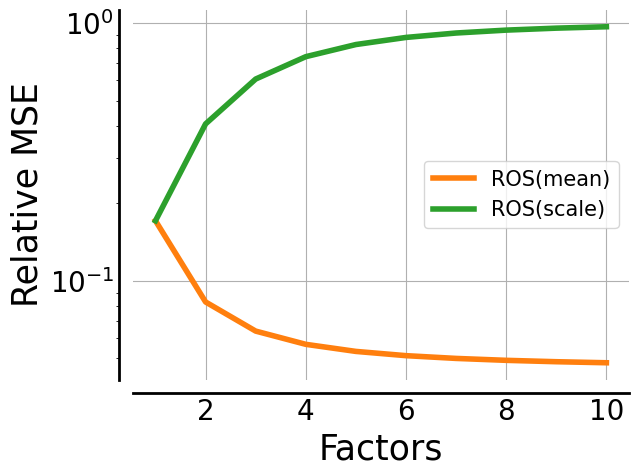

In [31]:
plt.plot(xx, aa, alpha = 1, label = 'ROS(mean)', color = cycle_colors[1], linewidth=4)
plt.plot(xx, bbb, alpha = 1, label = 'ROS(scale)',color = cycle_colors[2], linewidth=4)
plt.yscale('log')
annotate_and_decorate_axis(
    plt.gcf().axes[0], 'Factors', 'Relative MSE', labelsize=25, ticklabelsize=20,
)
plt.legend(fontsize=15)
plt.savefig('appendix_figures/figure12a.pdf', format='pdf', bbox_inches='tight')

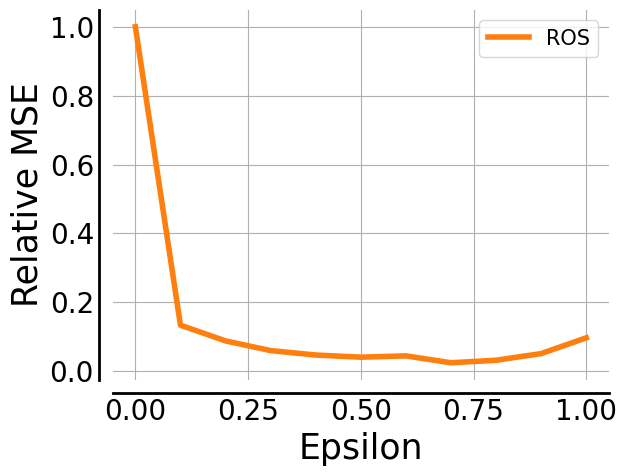

In [32]:
# Figure 12(b)
cc = np.zeros(11)
xx = np.array(range(11)) * 0.1
filer0 = 'data/Gridworld_ms/GridWorldM1S0_0_RobustOnPolicySampler1_MonteCarlo'
aaar0 = load_pickle_data(filer0)
datr0 = np.array(aaar0['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mser0 = (datr0-1)**2

fileo0 = 'data/Gridworld_ms/GridWorldM1S0_0_OnPolicySampler1_MonteCarlo'
aaao0 = load_pickle_data(fileo0)
dato0 = np.array(aaao0['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo0 = (dato0-1)**2

cc[0] = np.mean(mser0)/np.mean(mseo0)

filer1 = 'data/Gridworld_ms/GridWorldM1S0_1_RobustOnPolicySampler1_MonteCarlo'
aaar1 = load_pickle_data(filer1)
datr1 = np.array(aaar1['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mser1 = (datr1-1)**2

fileo1 = 'data/Gridworld_ms/GridWorldM1S0_1_OnPolicySampler1_MonteCarlo'
aaao1 = load_pickle_data(fileo1)
dato1 = np.array(aaao1['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo1 = (dato1-1)**2

cc[1] = np.mean(mser1)/np.mean(mseo1)

filer2 = 'data/Gridworld_ms/GridWorldM1S0_2_RobustOnPolicySampler1_MonteCarlo'
aaar2 = load_pickle_data(filer2)
datr2 = np.array(aaar2['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mser2 = (datr2-1)**2

fileo2 = 'data/Gridworld_ms/GridWorldM1S0_2_OnPolicySampler1_MonteCarlo'
aaao2 = load_pickle_data(fileo2)
dato2 = np.array(aaao2['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo2 = (dato2-1)**2

cc[2] = np.mean(mser2)/np.mean(mseo2)

filer3 = 'data/Gridworld_ms/GridWorldM1S0_3_RobustOnPolicySampler1_MonteCarlo'
aaar3 = load_pickle_data(filer3)
datr3 = np.array(aaar3['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mser3 = (datr3-1)**2

fileo3 = 'data/Gridworld_ms/GridWorldM1S0_3_OnPolicySampler1_MonteCarlo'
aaao3 = load_pickle_data(fileo3)
dato3 = np.array(aaao3['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo3 = (dato3-1)**2

cc[3] = np.mean(mser3)/np.mean(mseo3)

filer4 = 'data/Gridworld_ms/GridWorldM1S0_4_RobustOnPolicySampler1_MonteCarlo'
aaar4 = load_pickle_data(filer4)
datr4 = np.array(aaar4['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mser4 = (datr4-1)**2

fileo4 = 'data/Gridworld_ms/GridWorldM1S0_4_OnPolicySampler1_MonteCarlo'
aaao4 = load_pickle_data(fileo4)
dato4 = np.array(aaao4['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo4 = (dato4-1)**2

cc[4] = np.mean(mser4)/np.mean(mseo4)

filer5 = 'data/Gridworld_ms/GridWorldM1S0_5_RobustOnPolicySampler1_MonteCarlo'
aaar5 = load_pickle_data(filer5)
datr5 = np.array(aaar5['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mser5 = (datr5-1)**2

fileo5 = 'data/Gridworld_ms/GridWorldM1S0_5_OnPolicySampler1_MonteCarlo'
aaao5 = load_pickle_data(fileo5)
dato5 = np.array(aaao5['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo5 = (dato5-1)**2

cc[5] = np.mean(mser5)/np.mean(mseo5)

filer6 = 'data/Gridworld_ms/GridWorldM1S0_6_RobustOnPolicySampler1_MonteCarlo'
aaar6 = load_pickle_data(filer6)
datr6 = np.array(aaar6['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mser6 = (datr6-1)**2

fileo6 = 'data/Gridworld_ms/GridWorldM1S0_6_OnPolicySampler1_MonteCarlo'
aaao6 = load_pickle_data(fileo6)
dato6 = np.array(aaao6['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo6 = (dato6-1)**2

cc[6] = np.mean(mser6)/np.mean(mseo6)

filer7 = 'data/Gridworld_ms/GridWorldM1S0_7_RobustOnPolicySampler1_MonteCarlo'
aaar7 = load_pickle_data(filer7)
datr7 = np.array(aaar7['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mser7 = (datr7-1)**2

fileo7 = 'data/Gridworld_ms/GridWorldM1S0_7_OnPolicySampler1_MonteCarlo'
aaao7 = load_pickle_data(fileo7)
dato7 = np.array(aaao7['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo7 = (dato7-1)**2

cc[7] = np.mean(mser7)/np.mean(mseo7)

filer8 = 'data/Gridworld_ms/GridWorldM1S0_8_RobustOnPolicySampler1_MonteCarlo'
aaar8 = load_pickle_data(filer8)
datr8 = np.array(aaar8['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mser8 = (datr8-1)**2

fileo8 = 'data/Gridworld_ms/GridWorldM1S0_8_OnPolicySampler1_MonteCarlo'
aaao8 = load_pickle_data(fileo8)
dato8 = np.array(aaao8['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo8 = (dato8-1)**2

cc[8] = np.mean(mser8)/np.mean(mseo8)

filer9 = 'data/Gridworld_ms/GridWorldM1S0_9_RobustOnPolicySampler1_MonteCarlo'
aaar9 = load_pickle_data(filer9)
datr9 = np.array(aaar9['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mser9 = (datr9-1)**2

fileo9 = 'data/Gridworld_ms/GridWorldM1S0_9_OnPolicySampler1_MonteCarlo'
aaao9 = load_pickle_data(fileo9)
dato9 = np.array(aaao9['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo9 = (dato9-1)**2

cc[9] = np.mean(mser9)/np.mean(mseo9)

filer10 = 'data/Gridworld_ms/GridWorldM1S0_10_RobustOnPolicySampler1_MonteCarlo'
aaar10 = load_pickle_data(filer10)
datr10 = np.array(aaar10['estimations']['RobustOnPolicySampler', 'MonteCarlo'])
mser10 = (datr10-1)**2

fileo10 = 'data/Gridworld_ms/GridWorldM1S0_10_OnPolicySampler1_MonteCarlo'
aaao10 = load_pickle_data(fileo10)
dato10 = np.array(aaao10['estimations']['OnPolicySampler', 'MonteCarlo'])
mseo10 = (dato10-1)**2

cc[10] = np.mean(mser10)/np.mean(mseo10)

plt.plot(xx, cc, alpha = 1, label = 'ROS', color = cycle_colors[1], linewidth=4)
# plt.yscale('log')
annotate_and_decorate_axis(
    plt.gcf().axes[0], 'Epsilon', 'Relative MSE', labelsize=25, ticklabelsize=20
)
plt.legend(fontsize=15)
plt.savefig('appendix_figures/figure12b.pdf', format='pdf', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

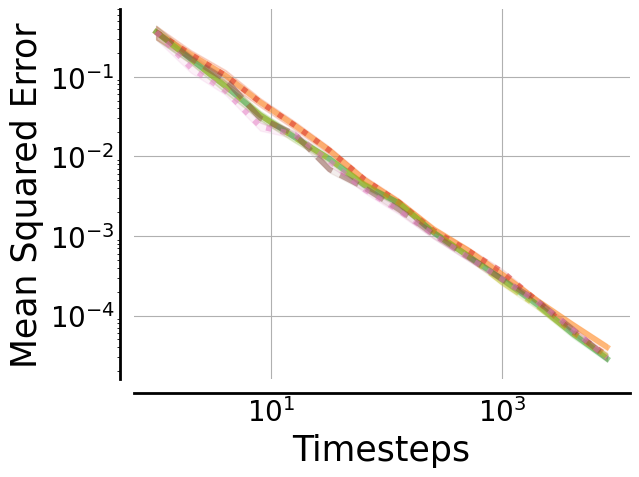

In [33]:
# Figure 13(a)
file1 = 'data/bandit/MultiBandit_5000_OnPolicySampler1_MonteCarlo'
aaa1 = load_pickle_data(file1)
x1 = aaa1['eval_steps']
dat1 = np.array(aaa1['estimations'][('OnPolicySampler','MonteCarlo')]) 
values1 = (dat1-1)**2

file2 = 'data/bandit/MultiBandit_5000_OnPolicySampler1_WeightedRegressionImportanceSampling'
aaa2 = load_pickle_data(file2)
x2 = aaa2['eval_steps']
dat2 = np.array(aaa2['estimations'][('OnPolicySampler', 'WeightedRegressionImportanceSampling')]) 
values2 = (dat2-1)**2

file3 = 'data/bandit/MultiBandit_5000_BehaviorPolicyGradient1_OrdinaryImportanceSampling'
aaa3 = load_pickle_data(file3)
x3 = aaa3['eval_steps']
dat3 = np.array(aaa3['estimations'][('BehaviorPolicyGradient', 'OrdinaryImportanceSampling')]) 
values3 = (dat3-1)**2

file4 = 'data/bandit/MultiBandit_5000_BehaviorPolicyGradient2_WeightedRegressionImportanceSampling'
aaa4 = load_pickle_data(file4)
x4 = aaa4['eval_steps']
dat4 = np.array(aaa4['estimations'][('BehaviorPolicyGradient', 'WeightedRegressionImportanceSampling')]) 
values4 = (dat4-1)**2

file5 = 'data/bandit/MultiBandit_5000_RobustOnPolicySampler3_MonteCarlo'
aaa5 = load_pickle_data(file5)
x5 = aaa5['eval_steps']
dat5 = np.array(aaa5['estimations'][('RobustOnPolicySampler', 'MonteCarlo')]) 
values5 = (dat5-1)**2

file6 = 'data/bandit/MultiBandit_5000_RobustOnPolicySampler3_WeightedRegressionImportanceSampling'
aaa6 = load_pickle_data(file6)
x6 = aaa6['eval_steps']
dat6 = np.array(aaa6['estimations'][('RobustOnPolicySampler', 'WeightedRegressionImportanceSampling')]) 
values6 = (dat6-1)**2

fig_13a_plot = {
    'OS-MC': (x1, values1, COLORS[1], '-'),
    'OS-WRIS': (x2, values2, COLORS[2], '-'),
    'BPG-OIS': (x3, values3, COLORS[3], ':'),
    'BPG-WRIS': (x4, values4, COLORS[8], '-.'),
    'ROS-MC': (x5, values5, COLORS[5], '--'),
    'ROS-WRIS': (x6, values6, COLORS[6], ':'),
}
draw_mean(
    fig_13a_plot,
    save_figure='appendix_figures/figure13a.pdf',
    export_legend_path='appendix_figures/figure13_legend.pdf',
    reduced_alpha=True
)

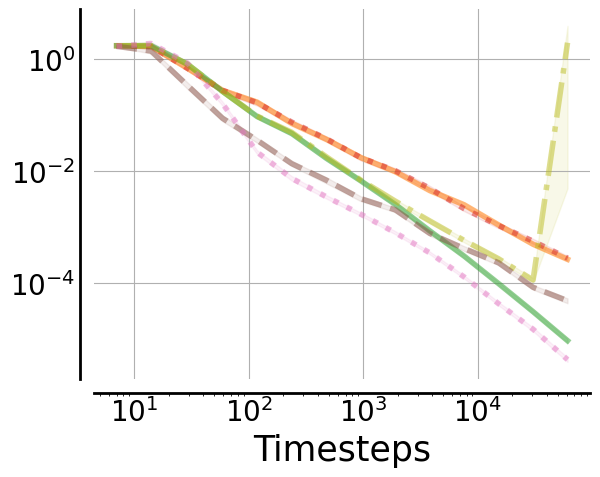

In [34]:
# Figure 13(b)
file1 = 'data/Gridworld/GridWorld_5000_OnPolicySampler1_MonteCarlo'
aaa1 = load_pickle_data(file1)
x1 = aaa1['eval_steps']
dat1 = np.array(aaa1['estimations'][('OnPolicySampler','MonteCarlo')]) 
values1 = (dat1-1)**2

file2 = 'data/Gridworld/GridWorld_5000_OnPolicySampler1_WeightedRegressionImportanceSampling'
aaa2 = load_pickle_data(file2)
x2 = aaa2['eval_steps']
dat2 = np.array(aaa2['estimations'][('OnPolicySampler', 'WeightedRegressionImportanceSampling')]) 
values2 = (dat2-1)**2

file3 = 'data/Gridworld/GridWorld_5000_BehaviorPolicyGradient2_OrdinaryImportanceSampling'
aaa3 = load_pickle_data(file3)
x3 = aaa3['eval_steps']
dat3 = np.array(aaa3['estimations'][('BehaviorPolicyGradient', 'OrdinaryImportanceSampling')]) 
values3 = (dat3-1)**2

file4 = 'data/Gridworld/GridWorld_5000_BehaviorPolicyGradient2_WeightedRegressionImportanceSampling'
aaa4 = load_pickle_data(file4)
x4 = aaa4['eval_steps']
dat4 = np.array(aaa4['estimations'][('BehaviorPolicyGradient', 'WeightedRegressionImportanceSampling')]) 
values4 = (dat4-1)**2

file5 = 'data/Gridworld/GridWorld_5000_RobustOnPolicySampler2_MonteCarlo'
aaa5 = load_pickle_data(file5)
x5 = aaa5['eval_steps']
dat5 = np.array(aaa5['estimations'][('RobustOnPolicySampler', 'MonteCarlo')]) 
values5 = (dat5-1)**2

file6 = 'data/Gridworld/GridWorld_5000_RobustOnPolicySampler3_WeightedRegressionImportanceSampling'
aaa6 = load_pickle_data(file6)
x6 = aaa6['eval_steps']
dat6 = np.array(aaa6['estimations'][('RobustOnPolicySampler', 'WeightedRegressionImportanceSampling')]) 
values6 = (dat6-1)**2

fig_13b_plot = {
    'OS-MC': (x1, values1, COLORS[1], '-'),
    'OS-WRIS': (x2, values2, COLORS[2], '-'),
    'BPG-OIS': (x3, values3, COLORS[3], ':'),
    'BPG-WRIS': (x4, values4, COLORS[8], '-.'),
    'ROS-MC': (x5, values5, COLORS[5], '--'),
    'ROS-WRIS': (x6, values6, COLORS[6], ':'),
}
draw_mean(
    fig_13b_plot,
    save_figure='appendix_figures/figure13b.pdf',
    plot_legend=False,
    show_y_label=False,
    reduced_alpha=True,
)

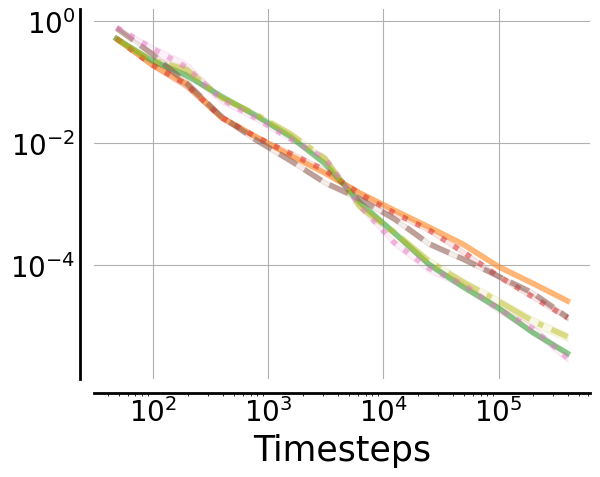

In [35]:
# Figure 13(c)
file1 = 'data/cartpole/CartPole_1000_OnPolicySampler1_MonteCarlo'
aaa1 = load_pickle_data(file1)
x1 = aaa1['eval_steps']
dat1 = np.array(aaa1['estimations'][('OnPolicySampler','MonteCarlo')]) 
values1 = (dat1-1)**2

file2 = 'data/cartpole/CartPole_1000_OnPolicySampler1_WeightedRegressionImportanceSampling'
aaa2 = load_pickle_data(file2)
x2 = aaa2['eval_steps']
dat2 = np.array(aaa2['estimations'][('OnPolicySampler', 'WeightedRegressionImportanceSampling')]) 
values2 = (dat2-1)**2

file3 = 'data/cartpole/CartPole_1000_BehaviorPolicyGradient1_OrdinaryImportanceSampling'
aaa3 = load_pickle_data(file3)
x3 = aaa3['eval_steps']
dat3 = np.array(aaa3['estimations'][('BehaviorPolicyGradient', 'OrdinaryImportanceSampling')]) 
values3 = (dat3-1)**2

file4 = 'data/cartpole/CartPole_1000_BehaviorPolicyGradient1_WeightedRegressionImportanceSampling'
aaa4 = load_pickle_data(file4)
x4 = aaa4['eval_steps']
dat4 = np.array(aaa4['estimations'][('BehaviorPolicyGradient', 'WeightedRegressionImportanceSampling')]) 
values4 = (dat4-1)**2

file5 = 'data/cartpole/CartPole_1000_RobustOnPolicySampler1_MonteCarlo'
aaa5 = load_pickle_data(file5)
x5 = aaa5['eval_steps']
dat5 = np.array(aaa5['estimations'][('RobustOnPolicySampler', 'MonteCarlo')]) 
values5 = (dat5-1)**2

file6 = 'data/cartpole/CartPole_1000_RobustOnPolicySampler1_WeightedRegressionImportanceSampling'
aaa6 = load_pickle_data(file6)
x6 = aaa6['eval_steps']
dat6 = np.array(aaa6['estimations'][('RobustOnPolicySampler', 'WeightedRegressionImportanceSampling')]) 
values6 = (dat6-1)**2

fig_13c_plot = {
    'OS-MC': (x1, values1, COLORS[1], '-'),
    'OS-WRIS': (x2, values2, COLORS[2], '-'),
    'BPG-OIS': (x3, values3, COLORS[3], ':'),
    'BPG-WRIS': (x4, values4, COLORS[8], '-.'),
    'ROS-MC': (x5, values5, COLORS[5], '--'),
    'ROS-WRIS': (x6, values6, COLORS[6], ':'),
}
draw_mean(
    fig_13c_plot,
    save_figure='appendix_figures/figure13c.pdf',
    plot_legend=False,
    show_y_label=False,
    reduced_alpha=True,
)

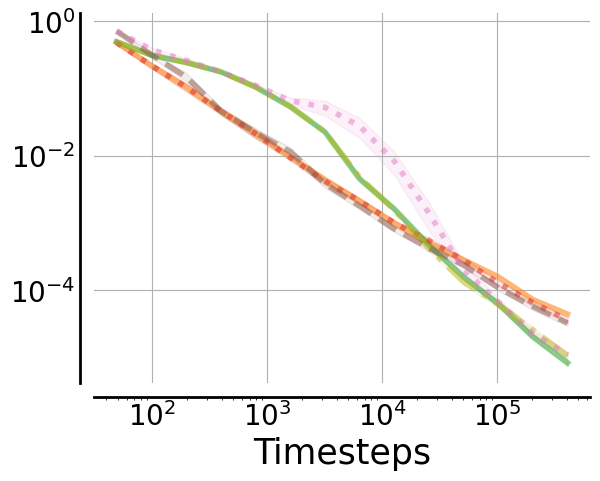

In [36]:
# Figure 13(d)
file1 = 'data/con_cartpole/CartPoleContinuous_3000_OnPolicySampler1_MonteCarlo'
aaa1 = load_pickle_data(file1)
x1 = aaa1['eval_steps']
dat1 = np.array(aaa1['estimations'][('OnPolicySampler','MonteCarlo')]) 
values1 = (dat1-1)**2

file2 = 'data/con_cartpole/CartPoleContinuous_3000_OnPolicySampler1_WeightedRegressionImportanceSampling'
aaa2 = load_pickle_data(file2)
x2 = aaa2['eval_steps']
dat2 = np.array(aaa2['estimations'][('OnPolicySampler', 'WeightedRegressionImportanceSampling')]) 
values2 = (dat2-1)**2

file3 = 'data/con_cartpole/CartPoleContinuous_3000_BehaviorPolicyGradient5_OrdinaryImportanceSampling'
aaa3 = load_pickle_data(file3)
x3 = aaa3['eval_steps']
dat3 = np.array(aaa3['estimations'][('BehaviorPolicyGradient', 'OrdinaryImportanceSampling')]) 
values3 = (dat3-1)**2

file4 = 'data/con_cartpole/CartPoleContinuous_3000_BehaviorPolicyGradient5_WeightedRegressionImportanceSampling'
aaa4 = load_pickle_data(file4)
x4 = aaa4['eval_steps']
dat4 = np.array(aaa4['estimations'][('BehaviorPolicyGradient', 'WeightedRegressionImportanceSampling')]) 
values4 = (dat4-1)**2

file5 = 'data/con_cartpole/CartPoleContinuous_3000_RobustOnPolicySampler2_MonteCarlo'
aaa5 = load_pickle_data(file5)
x5 = aaa5['eval_steps']
dat5 = np.array(aaa5['estimations'][('RobustOnPolicySampler', 'MonteCarlo')]) 
values5 = (dat5-1)**2

file6 = 'data/con_cartpole/CartPoleContinuous_3000_RobustOnPolicySampler2_WeightedRegressionImportanceSampling'
aaa6 = load_pickle_data(file6)
x6 = aaa6['eval_steps']
dat6 = np.array(aaa6['estimations'][('RobustOnPolicySampler', 'WeightedRegressionImportanceSampling')]) 
values6 = (dat6-1)**2

fig_13d_plot = {
    'OS-MC': (x1, values1, COLORS[1], '-'),
    'OS-WRIS': (x2, values2, COLORS[2], '-'),
    'BPG-OIS': (x3, values3, COLORS[3], ':'),
    'BPG-WRIS': (x4, values4, COLORS[8], '-.'),
    'ROS-MC': (x5, values5, COLORS[5], '--'),
    'ROS-WRIS': (x6, values6, COLORS[6], ':'),
}
draw_mean(
    fig_13d_plot,
    save_figure='appendix_figures/figure13d.pdf',
    plot_legend=False,
    show_y_label=False,
    reduced_alpha=True,
)

<Figure size 640x480 with 0 Axes>

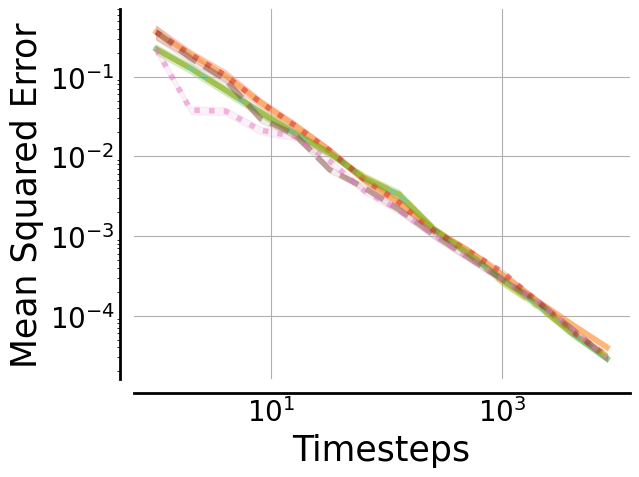

In [37]:
# Figure 14(a)
file1 = 'data/bandit/MultiBandit_5000_OnPolicySampler1_MonteCarlo'
aaa1 = load_pickle_data(file1)
x1 = aaa1['eval_steps']
dat1 = np.array(aaa1['estimations'][('OnPolicySampler','MonteCarlo')]) 
values1 = (dat1-1)**2

file2 = 'data/bandit/MultiBandit_5000_OnPolicySampler1_FitterQ'
aaa2 = load_pickle_data(file2)
x2 = aaa2['eval_steps']
dat2 = np.array(aaa2['estimations'][('OnPolicySampler', 'FitterQ')]) 
values2 = (dat2-1)**2

file3 = 'data/bandit/MultiBandit_5000_BehaviorPolicyGradient1_OrdinaryImportanceSampling'
aaa3 = load_pickle_data(file3)
x3 = aaa3['eval_steps']
dat3 = np.array(aaa3['estimations'][('BehaviorPolicyGradient', 'OrdinaryImportanceSampling')]) 
values3 = (dat3-1)**2

file4 = 'data/bandit/MultiBandit_5000_BehaviorPolicyGradient2_FitterQ'
aaa4 = load_pickle_data(file4)
x4 = aaa4['eval_steps']
dat4 = np.array(aaa4['estimations'][('BehaviorPolicyGradient', 'FitterQ')]) 
values4 = (dat4-1)**2

file5 = 'data/bandit/MultiBandit_5000_RobustOnPolicySampler3_MonteCarlo'
aaa5 = load_pickle_data(file5)
x5 = aaa5['eval_steps']
dat5 = np.array(aaa5['estimations'][('RobustOnPolicySampler', 'MonteCarlo')]) 
values5 = (dat5-1)**2

file6 = 'data/bandit/MultiBandit_5000_RobustOnPolicySampler3_FitterQ'
aaa6 = load_pickle_data(file6)
x6 = aaa6['eval_steps']
dat6 = np.array(aaa6['estimations'][('RobustOnPolicySampler', 'FitterQ')]) 
values6 = (dat6-1)**2

fig_14a_plot = {
    'OS-MC': (x1, values1, COLORS[1], '-'),
    'OS-FQE': (x2, values2, COLORS[2], '-'),
    'BPG-OIS': (x3, values3, COLORS[3], ':'),
    'BPG-FQE': (x4, values4, COLORS[8], '-.'),
    'ROS-MC': (x5, values5, COLORS[5], '--'),
    'ROS-FQE': (x6, values6, COLORS[6], ':'),
}
draw_mean(
    fig_14a_plot,
    save_figure='appendix_figures/figure14a.pdf',
    export_legend_path='appendix_figures/figure14_legend.pdf',
    reduced_alpha=True,
)

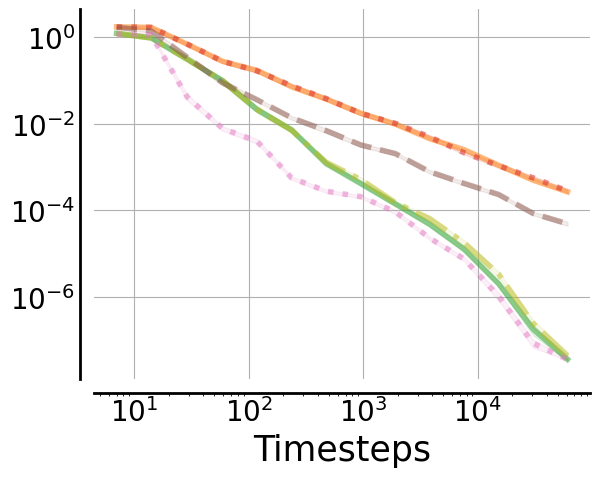

In [38]:
# Figure 14(b)
file1 = 'data/Gridworld/GridWorld_5000_OnPolicySampler1_MonteCarlo'
aaa1 = load_pickle_data(file1)
x1 = aaa1['eval_steps']
dat1 = np.array(aaa1['estimations'][('OnPolicySampler','MonteCarlo')]) 
values1 = (dat1-1)**2

file2 = 'data/Gridworld/GridWorld_5000_OnPolicySampler1_FitterQ'
aaa2 = load_pickle_data(file2)
x2 = aaa2['eval_steps']
dat2 = np.array(aaa2['estimations'][('OnPolicySampler', 'FitterQ')]) 
values2 = (dat2-1)**2

file3 = 'data/Gridworld/GridWorld_5000_BehaviorPolicyGradient2_OrdinaryImportanceSampling'
aaa3 = load_pickle_data(file3)
x3 = aaa3['eval_steps']
dat3 = np.array(aaa3['estimations'][('BehaviorPolicyGradient', 'OrdinaryImportanceSampling')]) 
values3 = (dat3-1)**2

file4 = 'data/Gridworld/GridWorld_5000_BehaviorPolicyGradient2_FitterQ'
aaa4 = load_pickle_data(file4)
x4 = aaa4['eval_steps']
dat4 = np.array(aaa4['estimations'][('BehaviorPolicyGradient', 'FitterQ')]) 
values4 = (dat4-1)**2

file5 = 'data/Gridworld/GridWorld_5000_RobustOnPolicySampler2_MonteCarlo'
aaa5 = load_pickle_data(file5)
x5 = aaa5['eval_steps']
dat5 = np.array(aaa5['estimations'][('RobustOnPolicySampler', 'MonteCarlo')]) 
values5 = (dat5-1)**2

file6 = 'data/Gridworld/GridWorld_5000_RobustOnPolicySampler3_FitterQ'
aaa6 = load_pickle_data(file6)
x6 = aaa6['eval_steps']
dat6 = np.array(aaa6['estimations'][('RobustOnPolicySampler', 'FitterQ')]) 
values6 = (dat6-1)**2

fig_14b_plot = {
    'OS-MC': (x1, values1, COLORS[1], '-'),
    'OS-FQE': (x2, values2, COLORS[2], '-'),
    'BPG-OIS': (x3, values3, COLORS[3], ':'),
    'BPG-FQE': (x4, values4, COLORS[8], '-.'),
    'ROS-MC': (x5, values5, COLORS[5], '--'),
    'ROS-FQE': (x6, values6, COLORS[6], ':'),
}
draw_mean(
    fig_14b_plot,
    save_figure='appendix_figures/figure14b.pdf',
    reduced_alpha=True,
    show_y_label=False,
    plot_legend=False,
)

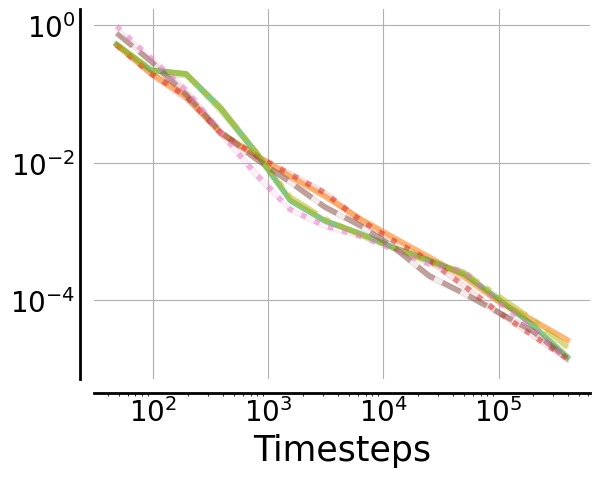

In [39]:
# Figure 14(c)
file1 = 'data/cartpole/CartPole_1000_OnPolicySampler1_MonteCarlo'
aaa1 = load_pickle_data(file1)
x1 = aaa1['eval_steps']
dat1 = np.array(aaa1['estimations'][('OnPolicySampler','MonteCarlo')]) 
values1 = (dat1-1)**2

file2 = 'data/cartpole/CartPole_1000_OnPolicySampler1_FitterQ'
aaa2 = load_pickle_data(file2)
x2 = aaa2['eval_steps']
dat2 = np.array(aaa2['estimations'][('OnPolicySampler', 'FitterQ')]) 
values2 = (dat2-1)**2

file3 = 'data/cartpole/CartPole_1000_BehaviorPolicyGradient1_OrdinaryImportanceSampling'
aaa3 = load_pickle_data(file3)
x3 = aaa3['eval_steps']
dat3 = np.array(aaa3['estimations'][('BehaviorPolicyGradient', 'OrdinaryImportanceSampling')]) 
values3 = (dat3-1)**2

file4 = 'data/cartpole/CartPole_1000_BehaviorPolicyGradient2_FitterQ'
aaa4 = load_pickle_data(file4)
x4 = aaa4['eval_steps']
dat4 = np.array(aaa4['estimations'][('BehaviorPolicyGradient', 'FitterQ')]) 
values4 = (dat4-1)**2

file5 = 'data/cartpole/CartPole_1000_RobustOnPolicySampler1_MonteCarlo'
aaa5 = load_pickle_data(file5)
x5 = aaa5['eval_steps']
dat5 = np.array(aaa5['estimations'][('RobustOnPolicySampler', 'MonteCarlo')]) 
values5 = (dat5-1)**2

file6 = 'data/cartpole/CartPole_1000_RobustOnPolicySampler2_FitterQ'
aaa6 = load_pickle_data(file6)
x6 = aaa6['eval_steps']
dat6 = np.array(aaa6['estimations'][('RobustOnPolicySampler', 'FitterQ')]) 
values6 = (dat6-1)**2

fig_14c_plot = {
    'OS-MC': (x1, values1, COLORS[1], '-'),
    'OS-FQE': (x2, values2, COLORS[2], '-'),
    'BPG-OIS': (x3, values3, COLORS[3], ':'),
    'BPG-FQE': (x4, values4, COLORS[8], '-.'),
    'ROS-MC': (x5, values5, COLORS[5], '--'),
    'ROS-FQE': (x6, values6, COLORS[6], ':'),
}
draw_mean(
    fig_14c_plot,
    save_figure='appendix_figures/figure14c.pdf',
    reduced_alpha=True,
    show_y_label=False,
    plot_legend=False,
)

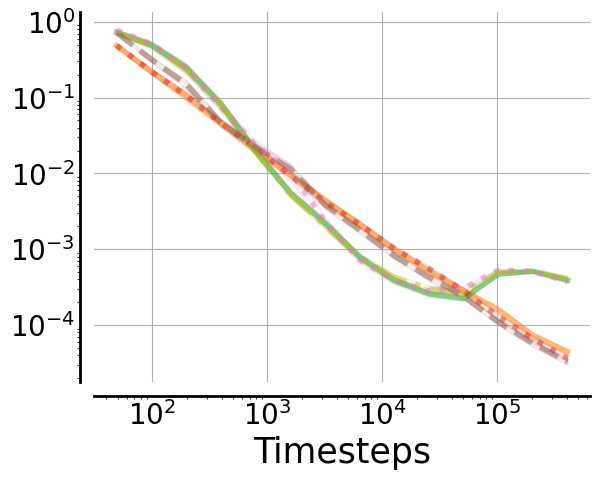

In [40]:
# Figure 14(d)
file1 = 'data/con_cartpole/CartPoleContinuous_3000_OnPolicySampler1_MonteCarlo'
aaa1 = load_pickle_data(file1)
x1 = aaa1['eval_steps']
dat1 = np.array(aaa1['estimations'][('OnPolicySampler','MonteCarlo')]) 
values1 = (dat1-1)**2

file2 = 'data/con_cartpole/CartPoleContinuous_3000_OnPolicySampler1_FitterQ'
aaa2 = load_pickle_data(file2)
x2 = aaa2['eval_steps']
dat2 = np.array(aaa2['estimations'][('OnPolicySampler', 'FitterQ')]) 
values2 = (dat2-1)**2

file3 = 'data/con_cartpole/CartPoleContinuous_3000_BehaviorPolicyGradient5_OrdinaryImportanceSampling'
aaa3 = load_pickle_data(file3)
x3 = aaa3['eval_steps']
dat3 = np.array(aaa3['estimations'][('BehaviorPolicyGradient', 'OrdinaryImportanceSampling')]) 
values3 = (dat3-1)**2

file4 = 'data/con_cartpole/CartPoleContinuous_3000_BehaviorPolicyGradient5_FitterQ'
aaa4 = load_pickle_data(file4)
x4 = aaa4['eval_steps']
dat4 = np.array(aaa4['estimations'][('BehaviorPolicyGradient', 'FitterQ')]) 
values4 = (dat4-1)**2

file5 = 'data/con_cartpole/CartPoleContinuous_3000_RobustOnPolicySampler2_MonteCarlo'
aaa5 = load_pickle_data(file5)
x5 = aaa5['eval_steps']
dat5 = np.array(aaa5['estimations'][('RobustOnPolicySampler', 'MonteCarlo')]) 
values5 = (dat5-1)**2

file6 = 'data/con_cartpole/CartPoleContinuous_3000_RobustOnPolicySampler2_FitterQ'
aaa6 = load_pickle_data(file6)
x6 = aaa6['eval_steps']
dat6 = np.array(aaa6['estimations'][('RobustOnPolicySampler', 'FitterQ')]) 
values6 = (dat6-1)**2

fig_14d_plot = {
    'OS-MC': (x1, values1, COLORS[1], '-'),
    'OS-FQE': (x2, values2, COLORS[2], '-'),
    'BPG-OIS': (x3, values3, COLORS[3], ':'),
    'BPG-FQE': (x4, values4, COLORS[8], '-.'),
    'ROS-MC': (x5, values5, COLORS[5], '--'),
    'ROS-FQE': (x6, values6, COLORS[6], ':'),
}
draw_mean(
    fig_14d_plot,
    save_figure='appendix_figures/figure14d.pdf',
    reduced_alpha=True,
    show_y_label=False,
    plot_legend=False,
)